In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os

from model import *

from src.modeling.run_model_single import (
    load_model, load_inputs, process_augment_inputs, batch_to_tensor
)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.append('../OncoNet_Public')
sys.path.append('../')

In [4]:
import torch
import torch.nn as nn
from torchgpipe import GPipe
import onconet.utils.parsing_with_line as parsing
import onconet.models.factory as model_factory
import torchvision
from torchvision import datasets, models, transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.is_available())

cuda
True


In [5]:
shared_parameters = {
    "device_type": "gpu",
    "gpu_number": 0,
    "max_crop_noise": None,
    "max_crop_size_noise": None,
    "batch_size": 4,
    "seed": 0,
    "augmentation": False,
    "use_hdf5": False,
}

In [6]:
random_number_generator = np.random.RandomState(shared_parameters["seed"])

image_only_parameters = shared_parameters.copy()
image_only_parameters["view"] = "L-CC"
image_only_parameters["use_heatmaps"] = False
image_only_parameters["model_path"] = "models/ImageOnly__ModeImage_weights.p"
model, device2 = load_model(image_only_parameters)
model = model.to(device)

In [7]:
import cv2
    
def grayscale_images(image_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    print("Converting images to grayscale...")
    for img_file in os.listdir(image_path):
        ii = cv2.imread(os.path.join(image_path, img_file))
        gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(output_path, img_file),gray_image)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [9]:
import cv2
ii = cv2.imread("images_png_2048x1664/00001447.png")
gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)

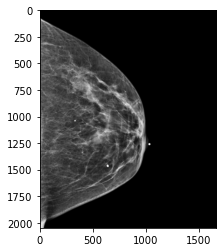

In [10]:
plt.imshow(ii)
plt.show()

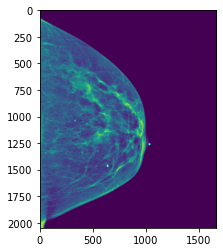

In [11]:
plt.imshow(gray_image)
plt.show()

# Load Pre-trained Models

In [12]:
# Some helper functions
import matplotlib.pyplot as plt
from IPython.display import Image
import pickle

# Store variables with pickle
def load_pkl(filename):
    var = pickle.load(open(filename, 'rb'))
    print('Loaded data from:', filename)
    return var

def store_pkl(var, filename):
    pickle.dump(var, open(filename, 'wb'), protocol=4)
    print('Stored data in:', filename)

# Display images
def display_image(num):
    return Image(filename='images_png_2048x1664_1_channel/{0:08d}.png'.format(num)) 

def display_tensor(tensor):
    plt.imshow(tensor.permute(1, 2, 0))

In [13]:
#display_image(1)

In [14]:
from mit_risk_data import MammoBCRiskDataset, Resize, FaceLeft, FaceRight, NormalizePix, ToTensor3D, mammo_collate
trans = transforms.Compose([FaceRight(), NormalizePix(7047.99, 12005.5), ToTensor3D()])
risk_dataset_t3 = torch.load('../time_set/risk_pred_GEHolo_4view_matchedSepCase_T3.pt')

In [15]:
risk_dataset_t3.transform

Compose(
)

In [16]:
risk_dataset_t3.transform = trans
risk_dataset_t3.transform

Compose(
)

In [17]:
risk_dataset_t3[0]['images']

{'same-cc': tensor([[[ 1.9369,  1.8823,  1.8103,  ..., -0.5871, -0.5871, -0.5871],
          [ 2.1556,  2.1010,  1.8702,  ..., -0.5871, -0.5871, -0.5871],
          [ 2.2770,  2.2276,  1.9316,  ..., -0.5871, -0.5871, -0.5871],
          ...,
          [-0.5871, -0.5871, -0.5871,  ..., -0.5871, -0.5871, -0.5871],
          [-0.5871, -0.5871, -0.5871,  ..., -0.5871, -0.5871, -0.5871],
          [-0.5871, -0.5871, -0.5871,  ..., -0.5871, -0.5871, -0.5871]]],
        dtype=torch.float64),
 'same-mlo': tensor([[[ 4.4759,  4.4290,  4.4517,  ..., -0.5871, -0.5871, -0.5871],
          [ 4.5457,  4.4545,  4.4679,  ..., -0.5871, -0.5871, -0.5871],
          [ 4.5443,  4.4558,  4.4196,  ..., -0.5871, -0.5871, -0.5871],
          ...,
          [ 1.8437,  1.4614,  1.6171,  ..., -0.5871, -0.5871, -0.5871],
          [ 1.9162,  1.4493,  1.4548,  ..., -0.5871, -0.5871, -0.5871],
          [ 1.9712,  1.6063,  1.5473,  ..., -0.5871, -0.5871, -0.5871]]],
        dtype=torch.float64),
 'opposite-cc': ten

In [18]:
dummy_img = torch.zeros(1, 1, 2048, 1664).to(device)
dummy_img.shape

torch.Size([1, 1, 2048, 1664])

In [19]:
a = model(dummy_img)

In [20]:
a[:, :2, 1]

tensor([[-2.3773, -3.0506]], device='cuda:0', grad_fn=<SelectBackward>)

In [21]:
import torch.nn.functional as F
print(F.softmax(a[:, :2, 1]))

tensor([[0.6623, 0.3377]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [22]:
predictions = np.exp(a.cpu().detach().numpy())[:, :2, 1]
predictions_dict = {
    "benign": float(predictions[0][0]),
    "malignant": float(predictions[0][1]),
}
print(predictions_dict)
del dummy_img

{'benign': 0.09280401468276978, 'malignant': 0.04732837155461311}


In [23]:
risk_dataset_t3[0]['images'].keys()

dict_keys(['same-cc', 'same-mlo', 'opposite-cc', 'opposite-mlo'])

In [24]:
if not os.path.exists('../ys_t3.pkl'):
    ys_t3 = np.array([ sample['label'].item() for sample in risk_dataset_t3])
    store_pkl(ys_t3, '../ys_t3.pkl')
else:
    ys_t3 = load_pkl('../ys_t3.pkl')

Loaded data from: ../ys_t3.pkl


In [25]:
ys_t3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [26]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [27]:
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12345)
for train_ix_, test_ix in skf.split(np.ones((len(ys_t3), 1)), ys_t3):
    train_y = ys_t3[train_ix_]
    test_prop = (1/n_folds)/(1 - 1/n_folds)
    train_ix, val_ix = train_test_split(train_ix_, test_size=test_prop, 
                                        stratify=train_y, 
                                        random_state=12345)
    print('train - {}, val - {}, test - {}'.format(
        np.bincount(ys_t3[train_ix]), np.bincount(ys_t3[val_ix]), np.bincount(ys_t3[test_ix])))

train - [64 21], val - [64 21], test - [64 22]
train - [64 21], val - [64 22], test - [64 21]
train - [64 21], val - [64 22], test - [64 21]


In [28]:
from torch.utils.data import Subset
train_dataset = Subset(risk_dataset_t3, train_ix)
val_dataset = Subset(risk_dataset_t3, val_ix)
test_dataset = Subset(risk_dataset_t3, test_ix)

In [29]:
train_y = ys_t3[train_ix]
val_y = ys_t3[val_ix]
test_y = ys_t3[test_ix]

In [30]:
f0, f1 = np.bincount(train_y)
train_w = np.zeros_like(train_y, dtype='float')
train_w[train_y==0] = 1/f0
train_w[train_y==1] = 1/f1

In [31]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

cpu_threads = 4
batch_size = 2

weighted_sampler = WeightedRandomSampler(
    train_w, len(train_y)//batch_size*batch_size, 
    replacement=True)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    num_workers=cpu_threads, sampler=weighted_sampler,
    collate_fn=mammo_collate)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, 
    num_workers=cpu_threads, drop_last=False,
    collate_fn=mammo_collate)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, 
    num_workers=cpu_threads, drop_last=False,
    collate_fn=mammo_collate)

In [32]:
"""
from time import time
start = time()
train_loss_, train_auc_ = val_loss(model, train_loader, return_auc=True)
print('Init avg train loss={:.3f}, auc={:.3f}'.format(train_loss_, train_auc_))
val_loss_, val_auc_ = val_loss(model, val_loader, return_auc=True)
print('Init avg val loss={:.3f}, auc={:.3f}'.format(val_loss_, val_auc_))
test_loss_, test_auc_ = val_loss(model, test_loader, return_auc=True)
print('Init avg test loss={:.3f}, auc={:.3f}'.format(test_loss_, test_auc_))
duration = time() - start
print('Time elapsed={:.1f}'.format(duration))

torch.cuda.empty_cache()
"""

"\nfrom time import time\nstart = time()\ntrain_loss_, train_auc_ = val_loss(model, train_loader, return_auc=True)\nprint('Init avg train loss={:.3f}, auc={:.3f}'.format(train_loss_, train_auc_))\nval_loss_, val_auc_ = val_loss(model, val_loader, return_auc=True)\nprint('Init avg val loss={:.3f}, auc={:.3f}'.format(val_loss_, val_auc_))\ntest_loss_, test_auc_ = val_loss(model, test_loader, return_auc=True)\nprint('Init avg test loss={:.3f}, auc={:.3f}'.format(test_loss_, test_auc_))\nduration = time() - start\nprint('Time elapsed={:.1f}'.format(duration))\n\ntorch.cuda.empty_cache()\n"

In [33]:
from tqdm import tqdm
from time import time
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.NLLLoss(reduction='mean').to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10) 

In [34]:
"""
start_epoch = 0
epochs = 20
train_loss = 0
check_iters = 5
best_name = 'best_model_2.pt'
best_auc = .0
start = time()
for i in range(start_epoch, start_epoch + epochs):
    for j, batch in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Each iteration is equivalent to 2*batch_size.
        bat_X_1 = batch['images']['same-cc'].float().to(device)
        bat_y = batch['label'].long().to(device)
        # forward-backward CC view images.
        #bat_logit_1, _, _ = model(bat_X_1)
        bat_logit_1 = model(bat_X_1)[:, :2, 1]
        #print(bat_logit_1)
        
        del bat_X_1
        
        torch.cuda.empty_cache()
        
        bat_logp_1 = F.log_softmax(bat_logit_1)
        
        del bat_logit_1
        
        torch.cuda.empty_cache()
        
        loss = criterion(bat_logp_1, bat_y)
        loss.backward()
        train_loss += loss.item()/2
        
        bat_X_2 = batch['images']['same-mlo'].float().to(device)
        # forward-backward MLO view images.
        #bat_logit_2, _, _ = model(bat_X_2)
        bat_logit_2 = model(bat_X_2)[:, :2, 1]
        
        del bat_X_2
        
        torch.cuda.empty_cache()
        
        bat_logp_2 = F.log_softmax(bat_logit_2)
        
        del bat_logit_2
        torch.cuda.empty_cache()
        
        loss = criterion(bat_logp_2, bat_y)
        loss.backward()
        train_loss += loss.item()/2
        # accumulate gradients from both CC and MLO images and 
        # then take a step to update.
        optimizer.step()
        total_iters = i*len(train_loader) + j + 1
        if total_iters%check_iters == 0:
            with torch.no_grad():
                avg_val_loss, val_auc = val_loss(model, val_loader, device, return_auc=True)
                
                scheduler.step(avg_val_loss)
                
                avg_train_loss = train_loss/check_iters
                print("Iter={}, avg train loss={:.3f}, avg val loss={:.3f}, auc={:.3f}".format(
                    total_iters, avg_train_loss, avg_val_loss, val_auc))
                if val_auc > best_auc:
                    best_auc = val_auc
                    torch.save(model.state_dict(), best_name)
                    print("Best model saved.")
                train_loss = 0
duration = time() - start
print('Time elapsed={:.1f}'.format(duration))
print('Best model loaded.')
"""

'\nstart_epoch = 0\nepochs = 20\ntrain_loss = 0\ncheck_iters = 5\nbest_name = \'best_model_2.pt\'\nbest_auc = .0\nstart = time()\nfor i in range(start_epoch, start_epoch + epochs):\n    for j, batch in enumerate(train_loader):\n        model.train()\n        optimizer.zero_grad()\n        # Each iteration is equivalent to 2*batch_size.\n        bat_X_1 = batch[\'images\'][\'same-cc\'].float().to(device)\n        bat_y = batch[\'label\'].long().to(device)\n        # forward-backward CC view images.\n        #bat_logit_1, _, _ = model(bat_X_1)\n        bat_logit_1 = model(bat_X_1)[:, :2, 1]\n        #print(bat_logit_1)\n        \n        del bat_X_1\n        \n        torch.cuda.empty_cache()\n        \n        bat_logp_1 = F.log_softmax(bat_logit_1)\n        \n        del bat_logit_1\n        \n        torch.cuda.empty_cache()\n        \n        loss = criterion(bat_logp_1, bat_y)\n        loss.backward()\n        train_loss += loss.item()/2\n        \n        bat_X_2 = batch[\'images\'

In [35]:
"""
model.load_state_dict(torch.load('best_model_2.pt'))
avg_test_loss, test_auc = val_loss(model, test_loader, device, return_auc=True)
print('Finetuned avg test loss={:.3f}, auc={:.3f}'.format(avg_test_loss, test_auc))
"""

"\nmodel.load_state_dict(torch.load('best_model_2.pt'))\navg_test_loss, test_auc = val_loss(model, test_loader, device, return_auc=True)\nprint('Finetuned avg test loss={:.3f}, auc={:.3f}'.format(avg_test_loss, test_auc))\n"

In [36]:
"""
test_auc_m = test_max_auc(model, test_loader, device)
print('Finetuned max-score-based auc={:.3f}'.format(test_auc_m))
"""

"\ntest_auc_m = test_max_auc(model, test_loader, device)\nprint('Finetuned max-score-based auc={:.3f}'.format(test_auc_m))\n"

# 3+ Years Prediction

In [42]:
from torch.optim import Adam

criterion = nn.NLLLoss(reduction='mean').to(device)
cpu_threads = 4
batch_size = 4
n_folds = 5
epochs = 20
subject_pool, exam_pool = [], []
pred_pool, label_pool, machine_pool = [], [], []
age_pool, race_pool, bmi_pool = [], [], []
birads_pool, libra_pool = [], []

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12345)
fold = 0
for train_ix_, test_ix in skf.split(np.ones((len(ys_t3), 1)), ys_t3):
    fold += 1
    # train-val-test idx.
    train_y = ys_t3[train_ix_]
    test_prop = (1/n_folds)/(1 - 1/n_folds)
    train_ix, val_ix = train_test_split(
        train_ix_, test_size=test_prop, 
        stratify=train_y, random_state=12345)
    # subset.
    train_dataset = Subset(risk_dataset_t3, train_ix)
    val_dataset = Subset(risk_dataset_t3, val_ix)
    test_dataset = Subset(risk_dataset_t3, test_ix)
    train_y = ys_t3[train_ix]
    val_y = ys_t3[val_ix]
    test_y = ys_t3[test_ix]
    # weighted sampler.
    f0, f1 = np.bincount(train_y)
    train_w = np.zeros_like(train_y, dtype='float')
    train_w[train_y==0] = 1/f0
    train_w[train_y==1] = 1/f1
    weighted_sampler = WeightedRandomSampler(
        train_w, len(train_y)//batch_size*batch_size, 
        replacement=True)
    # data loaders.
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, sampler=weighted_sampler,
        collate_fn=mammo_collate)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    
    image_only_parameters_rcc = shared_parameters.copy()
    image_only_parameters_rcc["view"] = "R-CC"
    image_only_parameters_rcc["use_heatmaps"] = False
    image_only_parameters_rcc["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    image_only_parameters_rmlo = shared_parameters.copy()
    image_only_parameters_rmlo["view"] = "R-MLO"
    image_only_parameters_rmlo["use_heatmaps"] = False
    image_only_parameters_rmlo["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    image_only_parameters_lmlo = shared_parameters.copy()
    image_only_parameters_lmlo["view"] = "L-MLO"
    image_only_parameters_lmlo["use_heatmaps"] = False
    image_only_parameters_lmlo["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    # Reset model before training.
    model, device_ = load_model(image_only_parameters_lmlo)
    model = nn.DataParallel(model)
    model = model.to(device)
    
    # train & test.
    best_name_ = 'best_model_{}_t3p_lmlo.pt'.format(fold)
    print('='*10, 'Fold', fold, '='*10)
    _, start_auc = val_loss(model, test_loader, device, return_auc=True)
    start_auc_m = test_max_auc(model, test_loader, device)
    
    print('Test AUC at start={:.3f}, max-score-based AUC={:.3f}'.format(
        start_auc, start_auc_m))
    
    train(model, train_loader, val_loader, best_name_, device, 
          epochs=epochs, lr=1e-5, check_iters=5, log_name='finetune_t3p_rcc.txt')
    
    print('Predicting on the test set...', end='')
    subject_list, exam_list, \
    pred_list, label_list, machine_list, \
    age_list, race_list, bmi_list, \
    birads_list, libra_list = do_test(model, test_loader, device)
    subject_pool.extend(subject_list)
    exam_pool.extend(exam_list)
    pred_pool.extend(pred_list)
    label_pool.extend(label_list)
    machine_pool.extend(machine_list)
    age_pool.extend(age_list)
    race_pool.extend(race_list)
    bmi_pool.extend(bmi_list)
    birads_pool.extend(birads_list)
    libra_pool.extend(libra_list) 
    # test AUC.
    _, fold_auc = val_loss(model, test_loader, device, return_auc=True)
    fold_auc_m = test_max_auc(model, test_loader, device)
    print('Done')
    print('Test AUC after training={:.3f}, max-score-based AUC={:.3f}'.format(
        fold_auc, fold_auc_m))
    if fold < n_folds:
        print("\n")

========== Fold 1 ==========
Test AUC at start=0.496, max-score-based AUC=0.515
Iter=5, avg train loss=1.275, avg val loss=0.668, auc=0.523
Best model saved.
Iter=10, avg train loss=0.741, avg val loss=0.685, auc=0.501
Iter=15, avg train loss=1.117, avg val loss=0.659, auc=0.493
Iter=20, avg train loss=0.943, avg val loss=0.635, auc=0.514
Iter=25, avg train loss=1.016, avg val loss=0.627, auc=0.505
Iter=30, avg train loss=0.720, avg val loss=0.643, auc=0.506
Iter=35, avg train loss=0.780, avg val loss=0.616, auc=0.539
Best model saved.
Iter=40, avg train loss=0.827, avg val loss=0.596, auc=0.569
Best model saved.
Iter=45, avg train loss=0.778, avg val loss=0.583, auc=0.592
Best model saved.
Iter=50, avg train loss=0.753, avg val loss=0.585, auc=0.593
Best model saved.
Iter=55, avg train loss=0.694, avg val loss=0.579, auc=0.606
Best model saved.
Iter=60, avg train loss=0.654, avg val loss=0.580, auc=0.616
Best model saved.
Iter=65, avg train loss=0.804, avg val loss=0.573, auc=0.625
Be

Iter=645, avg train loss=0.438, avg val loss=0.808, auc=0.532
Iter=650, avg train loss=0.590, avg val loss=0.816, auc=0.526
Iter=655, avg train loss=0.491, avg val loss=0.813, auc=0.529
Iter=660, avg train loss=0.581, avg val loss=0.805, auc=0.542
Iter=665, avg train loss=0.463, avg val loss=0.758, auc=0.548
Iter=670, avg train loss=0.441, avg val loss=0.725, auc=0.559
Iter=675, avg train loss=0.422, avg val loss=0.691, auc=0.540
Iter=680, avg train loss=0.411, avg val loss=0.715, auc=0.549
Iter=685, avg train loss=0.450, avg val loss=0.750, auc=0.527
Iter=690, avg train loss=0.429, avg val loss=0.753, auc=0.530
Iter=695, avg train loss=0.425, avg val loss=0.739, auc=0.529
Iter=700, avg train loss=0.521, avg val loss=0.768, auc=0.540
Iter=705, avg train loss=0.488, avg val loss=0.720, auc=0.530
Iter=710, avg train loss=0.335, avg val loss=0.679, auc=0.541
Iter=715, avg train loss=0.516, avg val loss=0.684, auc=0.549
Iter=720, avg train loss=0.464, avg val loss=0.720, auc=0.538
Iter=725

Iter=525, avg train loss=0.467, avg val loss=0.582, auc=0.653
Best model saved.
Iter=530, avg train loss=0.590, avg val loss=0.583, auc=0.638
Iter=535, avg train loss=0.513, avg val loss=0.596, auc=0.628
Iter=540, avg train loss=0.616, avg val loss=0.682, auc=0.615
Iter=545, avg train loss=0.479, avg val loss=0.714, auc=0.612
Iter=550, avg train loss=0.569, avg val loss=0.663, auc=0.618
Iter=555, avg train loss=0.480, avg val loss=0.617, auc=0.636
Iter=560, avg train loss=0.637, avg val loss=0.651, auc=0.631
Iter=565, avg train loss=0.467, avg val loss=0.617, auc=0.624
Iter=570, avg train loss=0.576, avg val loss=0.633, auc=0.601
Iter=575, avg train loss=0.573, avg val loss=0.689, auc=0.601
Iter=580, avg train loss=0.553, avg val loss=0.666, auc=0.585
Iter=585, avg train loss=0.573, avg val loss=0.667, auc=0.580
Iter=590, avg train loss=0.530, avg val loss=0.655, auc=0.584
Iter=595, avg train loss=0.500, avg val loss=0.615, auc=0.609
Iter=600, avg train loss=0.562, avg val loss=0.569, 

Iter=400, avg train loss=0.621, avg val loss=0.636, auc=0.526
Iter=405, avg train loss=0.556, avg val loss=0.658, auc=0.504
Iter=410, avg train loss=0.648, avg val loss=0.636, auc=0.521
Iter=415, avg train loss=0.580, avg val loss=0.701, auc=0.482
Iter=420, avg train loss=0.569, avg val loss=0.728, auc=0.514
Iter=425, avg train loss=0.571, avg val loss=0.629, auc=0.558
Iter=430, avg train loss=0.563, avg val loss=0.743, auc=0.497
Iter=435, avg train loss=0.526, avg val loss=0.681, auc=0.528
Iter=440, avg train loss=0.593, avg val loss=0.636, auc=0.536
Iter=445, avg train loss=0.533, avg val loss=0.671, auc=0.509
Iter=450, avg train loss=0.751, avg val loss=0.655, auc=0.500
Iter=455, avg train loss=0.636, avg val loss=0.794, auc=0.463
Iter=460, avg train loss=0.631, avg val loss=0.780, auc=0.460
Iter=465, avg train loss=0.535, avg val loss=0.814, auc=0.492
Iter=470, avg train loss=0.633, avg val loss=0.717, auc=0.498
Iter=475, avg train loss=0.699, avg val loss=0.662, auc=0.538
Iter=480

Iter=275, avg train loss=0.642, avg val loss=0.685, auc=0.539
Iter=280, avg train loss=0.556, avg val loss=0.688, auc=0.548
Iter=285, avg train loss=0.565, avg val loss=0.675, auc=0.551
Iter=290, avg train loss=0.619, avg val loss=0.677, auc=0.553
Iter=295, avg train loss=0.637, avg val loss=0.701, auc=0.542
Iter=300, avg train loss=0.524, avg val loss=0.713, auc=0.550
Iter=305, avg train loss=0.664, avg val loss=0.710, auc=0.547
Iter=310, avg train loss=0.558, avg val loss=0.696, auc=0.539
Iter=315, avg train loss=0.555, avg val loss=0.786, auc=0.569
Iter=320, avg train loss=0.503, avg val loss=0.713, auc=0.558
Iter=325, avg train loss=0.559, avg val loss=0.724, auc=0.540
Iter=330, avg train loss=0.562, avg val loss=0.728, auc=0.568
Iter=335, avg train loss=0.476, avg val loss=0.698, auc=0.555
Iter=340, avg train loss=0.642, avg val loss=0.694, auc=0.563
Iter=345, avg train loss=0.626, avg val loss=0.715, auc=0.548
Iter=350, avg train loss=0.582, avg val loss=0.722, auc=0.548
Iter=355

Iter=155, avg train loss=0.619, avg val loss=0.706, auc=0.515
Iter=160, avg train loss=0.650, avg val loss=0.663, auc=0.515
Iter=165, avg train loss=0.632, avg val loss=0.692, auc=0.517
Iter=170, avg train loss=0.601, avg val loss=0.689, auc=0.537
Iter=175, avg train loss=0.600, avg val loss=0.683, auc=0.527
Iter=180, avg train loss=0.704, avg val loss=0.664, auc=0.530
Iter=185, avg train loss=0.708, avg val loss=0.651, auc=0.526
Iter=190, avg train loss=0.627, avg val loss=0.637, auc=0.535
Iter=195, avg train loss=0.589, avg val loss=0.654, auc=0.531
Iter=200, avg train loss=0.565, avg val loss=0.655, auc=0.524
Iter=205, avg train loss=0.765, avg val loss=0.620, auc=0.542
Iter=210, avg train loss=0.652, avg val loss=0.657, auc=0.538
Iter=215, avg train loss=0.572, avg val loss=0.675, auc=0.524
Iter=220, avg train loss=0.653, avg val loss=0.626, auc=0.540
Iter=225, avg train loss=0.614, avg val loss=0.627, auc=0.543
Iter=230, avg train loss=0.629, avg val loss=0.649, auc=0.537
Iter=235

In [43]:
all_subj_t3_lmlo = np.concatenate(subject_pool)
all_exam_t3_lmlo = np.concatenate(exam_pool)
all_preds_t3_lmlo = torch.cat(pred_pool)
all_labels_t3_lmlo = torch.cat(label_pool)
all_preds_t3_lmlo = all_preds_t3_lmlo.cpu().numpy()
all_labels_t3_lmlo = all_labels_t3_lmlo.numpy()
all_probs_max_t3_lmlo = all_preds_t3_lmlo.max(1)
all_machines_t3_lmlo = np.concatenate(machine_pool)
all_ages_t3_lmlo = np.concatenate(age_pool)
all_races_t3_lmlo = np.concatenate(race_pool)
all_bmis_t3_lmlo = np.concatenate(bmi_pool)
all_birads_t3_lmlo = np.concatenate(birads_pool)
all_libras_t3_lmlo = np.concatenate(libra_pool)

In [102]:
all_subj_t3_lmlo = [ '{:06d}'.format(s) for s in all_subj_t3_lmlo]
all_subj_t3_lmlo[:3]

['009112', '050212', '062061']

In [103]:
import pandas as pd
df_t3_lmlo = pd.DataFrame.from_dict(
    {'subject': all_subj_t3_lmlo, 'exam': all_exam_t3_lmlo, 'is_ge': all_machines_t3_lmlo, 
     'age': all_ages_t3_lmlo, 'race': all_races_t3_lmlo, 'bmi': all_bmis_t3_lmlo, 
     'birads': all_birads_t3_lmlo,})
df_t3_lmlo.head()

,subject,exam,is_ge,age,race,bmi,birads
0,009112,1,1,48,6,29.679908,b
1,050212,1,1,42,8,29.071513,b
2,062061,1,1,41,8,29.880615,c
3,020549,1,1,62,8,26.879516,c
4,045170,1,1,64,1,23.643988,b


In [104]:
d_ = np.concatenate([all_preds_t3_lmlo, all_labels_t3_lmlo[:, np.newaxis]], axis=1)
d_[:3]
df_t3_lmlo = pd.concat([df_t3_lmlo, pd.DataFrame(d_)], axis=1)
df_t3_lmlo.head()
df_t3_lmlo = df_t3_lmlo.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t3_lmlo = df_t3_lmlo.astype({'is_case': 'int8'})
df_t3_lmlo.head()
df_t3_lmlo.to_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_lmlo.csv', index=False)

In [105]:
df_t3_lmlo

,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,009112,1,1,48,6,29.679908,b,0.304521,0.232105,0.274591,0.258612,0
1,050212,1,1,42,8,29.071513,b,0.412983,0.372199,0.339143,0.416420,0
2,062061,1,1,41,8,29.880615,c,0.273903,0.369669,0.223389,0.372314,0
3,020549,1,1,62,8,26.879516,c,0.389335,0.456041,0.368480,0.516701,0
4,045170,1,1,64,1,23.643988,b,0.598203,0.596657,0.314678,0.534118,0
...,...,...,...,...,...,...,...,...,...,...,...,...
251,104915,2,1,47,8,30.625144,b,0.250022,0.205919,0.429894,0.361700,0
252,780928,3,1,66,4,21.456605,c,0.248418,0.305946,0.220482,0.278784,1
253,195698,3,1,73,8,34.784098,b,0.118622,0.149065,0.096667,0.212740,0
254,230544,6,1,58,8,24.735432,c,0.543312,0.649607,0.273528,0.481383,0


In [113]:
all_preds_t3_lcc = pd.read_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_lcc.csv').iloc[:, [7,8,9,10]].values
all_preds_t3_rcc = pd.read_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_rcc.csv').iloc[:, [7,8,9,10]].values
all_preds_t3_rmlo = pd.read_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_rmlo.csv').iloc[:, [7,8,9,10]].values
all_preds_t3_lmlo = pd.read_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_lmlo.csv').iloc[:, [7,8,9,10]].values

In [114]:
avg_preds_t3 = (all_preds_t3_lmlo + all_preds_t3_lcc + all_preds_t3_rcc + all_preds_t3_rmlo) / 4

In [115]:
print('lmlo', all_preds_t3_lmlo)
print('lcc', all_preds_t3_lcc)
print('rcc', all_preds_t3_rcc)
print('rmlo', all_preds_t3_rmlo)

lmlo [[0.3045212  0.23210508 0.2745908  0.25861162]
 [0.4129827  0.37219867 0.33914253 0.41641963]
 [0.27390337 0.36966935 0.22338854 0.37231356]
 ...
 [0.11862215 0.14906469 0.09666682 0.21273951]
 [0.5433124  0.6496068  0.27352816 0.48138282]
 [0.14018653 0.18022181 0.10753763 0.14898185]]
lcc [[0.20317103 0.16945077 0.31250197 0.5297075 ]
 [0.3365171  0.5484205  0.28681237 0.65435016]
 [0.14965224 0.084284   0.06922546 0.2652455 ]
 ...
 [0.32699254 0.34328938 0.33800042 0.33058527]
 [0.56082565 0.5238925  0.7311519  0.65048933]
 [0.25710955 0.15362966 0.214254   0.14270675]]
rcc [[0.15563513 0.17080535 0.19516897 0.24901165]
 [0.254623   0.24362631 0.32191047 0.52902853]
 [0.15186371 0.04103323 0.07087473 0.22386558]
 ...
 [0.3782608  0.36807624 0.39721835 0.34895813]
 [0.42556557 0.43215024 0.5005677  0.49874818]
 [0.31781304 0.17652683 0.28034237 0.19249876]]
rmlo [[0.50077754 0.251973   0.41222876 0.254368  ]
 [0.5467737  0.5569067  0.47044453 0.6245646 ]
 [0.45830807 0.65846    

In [116]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3_lmlo)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rmlo, avg_preds_t3.max(axis=1))))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rmlo, avg_preds_t3.mean(axis=1))))

N=256
4view max AUC=0.636
4view mean AUC=0.623


In [101]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3_lmlo)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rmlo, avg_preds_t3.max(axis=1))))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rmlo, avg_preds_t3.mean(axis=1))))

N=256
4view max AUC=0.636
4view mean AUC=0.623


In [44]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3_lmlo)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3_lmlo, all_probs_max_t3_lmlo)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3_lmlo, all_preds_t3_lmlo.mean(axis=1))))

N=256
4view max AUC=0.594
4view mean AUC=0.601


In [39]:
all_subj_t3_rmlo = np.concatenate(subject_pool)
all_exam_t3_rmlo = np.concatenate(exam_pool)
all_preds_t3_rmlo = torch.cat(pred_pool)
all_labels_t3_rmlo = torch.cat(label_pool)
all_preds_t3_rmlo = all_preds_t3_rmlo.cpu().numpy()
all_labels_t3_rmlo = all_labels_t3_rmlo.numpy()
all_probs_max_t3_rmlo = all_preds_t3_rmlo.max(1)
all_machines_t3_rmlo = np.concatenate(machine_pool)
all_ages_t3_rmlo = np.concatenate(age_pool)
all_races_t3_rmlo = np.concatenate(race_pool)
all_bmis_t3_rmlo = np.concatenate(bmi_pool)
all_birads_t3_rmlo = np.concatenate(birads_pool)
all_libras_t3_rmlo = np.concatenate(libra_pool)

In [106]:
df_t3_rmlo = pd.DataFrame.from_dict(
    {'subject': all_subj_t3_rmlo, 'exam': all_exam_t3_rmlo, 'is_ge': all_machines_t3_rmlo, 
     'age': all_ages_t3_rmlo, 'race': all_races_t3_rmlo, 'bmi': all_bmis_t3_rmlo, 
     'birads': all_birads_t3_rmlo,})
df_t3_rmlo.head()
d_ = np.concatenate([all_preds_t3_rmlo, all_labels_t3_rmlo[:, np.newaxis]], axis=1)
d_[:3]
df_t3_rmlo = pd.concat([df_t3_rmlo, pd.DataFrame(d_)], axis=1)
df_t3_rmlo.head()
df_t3_rmlo = df_t3_rmlo.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t3_rmlo = df_t3_rmlo.astype({'is_case': 'int8'})
df_t3_rmlo.head()
df_t3_rmlo.to_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_rmlo.csv', index=False)
df_t3_rmlo

,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,9112,1,1,48,6,29.679908,b,0.500778,0.251973,0.412229,0.254368,0
1,50212,1,1,42,8,29.071513,b,0.546774,0.556907,0.470445,0.624565,0
2,62061,1,1,41,8,29.880615,c,0.458308,0.658460,0.324673,0.493476,0
3,20549,1,1,62,8,26.879516,c,0.553072,0.641456,0.532164,0.601776,0
4,45170,1,1,64,1,23.643988,b,0.747165,0.763433,0.287816,0.793160,0
...,...,...,...,...,...,...,...,...,...,...,...,...
251,104915,2,1,47,8,30.625144,b,0.383301,0.205719,0.394153,0.358733,0
252,780928,3,1,66,4,21.456605,c,0.203912,0.160643,0.217358,0.192662,1
253,195698,3,1,73,8,34.784098,b,0.031179,0.067112,0.043182,0.167024,0
254,230544,6,1,58,8,24.735432,c,0.364098,0.445089,0.232057,0.410728,0


In [41]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3_rmlo)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rmlo, all_probs_max_t3_rmlo)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rmlo, all_preds_t3_rmlo.mean(axis=1))))

N=256
4view max AUC=0.621
4view mean AUC=0.610


In [36]:
all_subj_t3_rcc = np.concatenate(subject_pool)
all_exam_t3_rcc = np.concatenate(exam_pool)
all_preds_t3_rcc = torch.cat(pred_pool)
all_labels_t3_rcc = torch.cat(label_pool)
all_preds_t3_rcc = all_preds_t3_rcc.cpu().numpy()
all_labels_t3_rcc = all_labels_t3_rcc.numpy()
all_probs_max_t3_rcc = all_preds_t3_rcc.max(1)
all_machines_t3_rcc = np.concatenate(machine_pool)
all_ages_t3_rcc = np.concatenate(age_pool)
all_races_t3_rcc = np.concatenate(race_pool)
all_bmis_t3_rcc = np.concatenate(bmi_pool)
all_birads_t3_rcc = np.concatenate(birads_pool)
all_libras_t3_rcc = np.concatenate(libra_pool)

In [107]:
df_t3_rcc = pd.DataFrame.from_dict(
    {'subject': all_subj_t3_rcc, 'exam': all_exam_t3_rcc, 'is_ge': all_machines_t3_rcc, 
     'age': all_ages_t3_rcc, 'race': all_races_t3_rcc, 'bmi': all_bmis_t3_rcc, 
     'birads': all_birads_t3_rcc,})
print(df_t3_rcc.head())
d_ = np.concatenate([all_preds_t3_rcc, all_labels_t3_rcc[:, np.newaxis]], axis=1)
d_[:3]
df_t3_rcc = pd.concat([df_t3_rcc, pd.DataFrame(d_)], axis=1)
df_t3_rcc.head()
df_t3_rcc = df_t3_rcc.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t3_rcc = df_t3_rcc.astype({'is_case': 'int8'})
df_t3_rcc.head()
df_t3_rcc.to_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train_rcc.csv', index=False)
df_t3_rcc

   subject  exam  is_ge  age race        bmi birads
0     9112     1      1   48    6  29.679908      b
1    50212     1      1   42    8  29.071513      b
2    62061     1      1   41    8  29.880615      c
3    20549     1      1   62    8  26.879516      c
4    45170     1      1   64    1  23.643988      b


,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,9112,1,1,48,6,29.679908,b,0.155635,0.170805,0.195169,0.249012,0
1,50212,1,1,42,8,29.071513,b,0.254623,0.243626,0.321910,0.529029,0
2,62061,1,1,41,8,29.880615,c,0.151864,0.041033,0.070875,0.223866,0
3,20549,1,1,62,8,26.879516,c,0.550666,0.762339,0.488756,0.786969,0
4,45170,1,1,64,1,23.643988,b,0.470914,0.622266,0.262973,0.359517,0
...,...,...,...,...,...,...,...,...,...,...,...,...
251,104915,2,1,47,8,30.625144,b,0.261728,0.139807,0.327221,0.294291,0
252,780928,3,1,66,4,21.456605,c,0.319006,0.343166,0.260633,0.203384,1
253,195698,3,1,73,8,34.784098,b,0.378261,0.368076,0.397218,0.348958,0
254,230544,6,1,58,8,24.735432,c,0.425566,0.432150,0.500568,0.498748,0


In [37]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3_rcc)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rcc, all_probs_max_t3_rcc)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3_rcc, all_preds_t3_rcc.mean(axis=1))))

N=256
4view max AUC=0.575
4view mean AUC=0.597


In [38]:
all_subj_t3 = np.concatenate(subject_pool)
all_exam_t3 = np.concatenate(exam_pool)
all_preds_t3 = torch.cat(pred_pool)
all_labels_t3 = torch.cat(label_pool)
all_preds_t3 = all_preds_t3.cpu().numpy()
all_labels_t3 = all_labels_t3.numpy()
all_probs_max_t3 = all_preds_t3.max(1)
all_machines_t3 = np.concatenate(machine_pool)
all_ages_t3 = np.concatenate(age_pool)
all_races_t3 = np.concatenate(race_pool)
all_bmis_t3 = np.concatenate(bmi_pool)
all_birads_t3 = np.concatenate(birads_pool)
all_libras_t3 = np.concatenate(libra_pool)

In [72]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3, all_probs_max_t3)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3, all_preds_t3.mean(axis=1))))

N=256
4view max AUC=0.596
4view mean AUC=0.596


In [73]:
all_subj_t3 = [ '{:06d}'.format(s) for s in all_subj_t3]
all_subj_t3[:3]

['009112', '050212', '062061']

In [74]:
import pandas as pd
df_t3 = pd.DataFrame.from_dict(
    {'subject': all_subj_t3, 'exam': all_exam_t3, 'is_ge': all_machines_t3, 
     'age': all_ages_t3, 'race': all_races_t3, 'bmi': all_bmis_t3, 
     'birads': all_birads_t3,})
df_t3.head()

,subject,exam,is_ge,age,race,bmi,birads
0,009112,1,1,48,6,29.679908,b
1,050212,1,1,42,8,29.071513,b
2,062061,1,1,41,8,29.880615,c
3,020549,1,1,62,8,26.879516,c
4,045170,1,1,64,1,23.643988,b


In [75]:
d_ = np.concatenate([all_preds_t3, all_labels_t3[:, np.newaxis]], axis=1)
d_[:3]

array([[0.20317103, 0.16945077, 0.31250197, 0.5297075 , 0.        ],
       [0.3365171 , 0.5484205 , 0.28681237, 0.65435016, 0.        ],
       [0.14965224, 0.084284  , 0.06922546, 0.2652455 , 0.        ]],
      dtype=float32)

In [76]:
df_t3 = pd.concat([df_t3, pd.DataFrame(d_)], axis=1)
df_t3.head()

,subject,exam,is_ge,age,race,bmi,birads,0,1,2,3,4
0,009112,1,1,48,6,29.679908,b,0.203171,0.169451,0.312502,0.529707,0.0
1,050212,1,1,42,8,29.071513,b,0.336517,0.548420,0.286812,0.654350,0.0
2,062061,1,1,41,8,29.880615,c,0.149652,0.084284,0.069225,0.265245,0.0
3,020549,1,1,62,8,26.879516,c,0.592148,0.875797,0.532543,0.898938,0.0
4,045170,1,1,64,1,23.643988,b,0.720334,0.892669,0.320591,0.756474,0.0


In [77]:
df_t3 = df_t3.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t3 = df_t3.astype({'is_case': 'int8'})
df_t3.head()

,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,009112,1,1,48,6,29.679908,b,0.203171,0.169451,0.312502,0.529707,0
1,050212,1,1,42,8,29.071513,b,0.336517,0.548420,0.286812,0.654350,0
2,062061,1,1,41,8,29.880615,c,0.149652,0.084284,0.069225,0.265245,0
3,020549,1,1,62,8,26.879516,c,0.592148,0.875797,0.532543,0.898938,0
4,045170,1,1,64,1,23.643988,b,0.720334,0.892669,0.320591,0.756474,0


In [78]:
df_t3.to_csv('../time_set/finetuned_pred_score_4view_T3p_nyu_single_view_train.csv', index=False)

In [52]:
roc_auc_score(all_labels_t3, all_preds_t3.mean(axis=1))

0.5961100260416667

In [53]:
roc_auc_score(all_labels_t3, all_preds_t3.max(axis=1))

0.5958658854166666

# 1+ Years Predicton

In [46]:
risk_dataset_t1p = torch.load('../time_set/risk_pred_GEHolo_4view_matchedSepCase_T1+.pt')
len(risk_dataset_t1p)

352

In [47]:
risk_dataset_t1p.transform = trans
risk_dataset_t1p.transform

Compose(
)

In [48]:
ys_t1p = load_pkl('ys_t1p.pkl')

Loaded data from: ys_t1p.pkl


In [59]:
from torch.optim import Adam

criterion = nn.NLLLoss(reduction='mean').to(device)
cpu_threads = 4
batch_size = 4
n_folds = 5
epochs = 20
subject_pool, exam_pool = [], []
pred_pool, label_pool, machine_pool = [], [], []
age_pool, race_pool, bmi_pool = [], [], []
birads_pool, libra_pool = [], []

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12345)
fold = 0
for train_ix_, test_ix in skf.split(np.ones((len(ys_t1p), 1)), ys_t1p):
    fold += 1
    # train-val-test idx.
    train_y = ys_t1p[train_ix_]
    test_prop = (1/n_folds)/(1 - 1/n_folds)
    train_ix, val_ix = train_test_split(
        train_ix_, test_size=test_prop, 
        stratify=train_y, random_state=12345)
    # subset.
    train_dataset = Subset(risk_dataset_t1p, train_ix)
    val_dataset = Subset(risk_dataset_t1p, val_ix)
    test_dataset = Subset(risk_dataset_t1p, test_ix)
    train_y = ys_t1p[train_ix]
    val_y = ys_t1p[val_ix]
    test_y = ys_t1p[test_ix]
    # weighted sampler.
    f0, f1 = np.bincount(train_y)
    train_w = np.zeros_like(train_y, dtype='float')
    train_w[train_y==0] = 1/f0
    train_w[train_y==1] = 1/f1
    weighted_sampler = WeightedRandomSampler(
        train_w, len(train_y)//batch_size*batch_size, 
        replacement=True)
    # data loaders.
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, sampler=weighted_sampler,
        collate_fn=mammo_collate)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    
    image_only_parameters_rcc = shared_parameters.copy()
    image_only_parameters_rcc["view"] = "R-CC"
    image_only_parameters_rcc["use_heatmaps"] = False
    image_only_parameters_rcc["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    image_only_parameters_rmlo = shared_parameters.copy()
    image_only_parameters_rmlo["view"] = "R-MLO"
    image_only_parameters_rmlo["use_heatmaps"] = False
    image_only_parameters_rmlo["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    image_only_parameters_lmlo = shared_parameters.copy()
    image_only_parameters_lmlo["view"] = "L-MLO"
    image_only_parameters_lmlo["use_heatmaps"] = False
    image_only_parameters_lmlo["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    # Reset model before training.
    model, device_ = load_model(image_only_parameters_rcc)
    model = nn.DataParallel(model)
    model = model.to(device)
    
    # train & test.
    best_name_ = 'best_model_{}_t1p_second_run_rcc.pt'.format(fold)
    print('='*10, 'Fold', fold, '='*10)
    _, start_auc = val_loss(model, test_loader, device, return_auc=True)
    start_auc_m = test_max_auc(model, test_loader, device)
    
    print('Test AUC at start={:.3f}, max-score-based AUC={:.3f}'.format(
        start_auc, start_auc_m))
    
    train(model, train_loader, val_loader, best_name_, device, 
          epochs=epochs, lr=1e-5, check_iters=5, log_name='finetune_t1p_second_run.txt')
    
    print('Predicting on the test set...', end='')
    subject_list, exam_list, \
    pred_list, label_list, machine_list, \
    age_list, race_list, bmi_list, \
    birads_list, libra_list = do_test(model, test_loader, device)
    subject_pool.extend(subject_list)
    exam_pool.extend(exam_list)
    pred_pool.extend(pred_list)
    label_pool.extend(label_list)
    machine_pool.extend(machine_list)
    age_pool.extend(age_list)
    race_pool.extend(race_list)
    bmi_pool.extend(bmi_list)
    birads_pool.extend(birads_list)
    libra_pool.extend(libra_list) 
    # test AUC.
    _, fold_auc = val_loss(model, test_loader, device, return_auc=True)
    fold_auc_m = test_max_auc(model, test_loader, device)
    print('Done')
    print('Test AUC after training={:.3f}, max-score-based AUC={:.3f}'.format(
        fold_auc, fold_auc_m))
    if fold < n_folds:
        print("\n")

========== Fold 1 ==========
Test AUC at start=0.511, max-score-based AUC=0.515
Iter=5, avg train loss=1.056, avg val loss=0.629, auc=0.389
Best model saved.
Iter=10, avg train loss=1.088, avg val loss=0.627, auc=0.402
Best model saved.
Iter=15, avg train loss=1.117, avg val loss=0.623, auc=0.406
Best model saved.
Iter=20, avg train loss=0.789, avg val loss=0.611, auc=0.440
Best model saved.
Iter=25, avg train loss=0.801, avg val loss=0.604, auc=0.430
Iter=30, avg train loss=0.650, avg val loss=0.605, auc=0.445
Best model saved.
Iter=35, avg train loss=0.675, avg val loss=0.600, auc=0.475
Best model saved.
Iter=40, avg train loss=0.693, avg val loss=0.597, auc=0.499
Best model saved.
Iter=45, avg train loss=0.681, avg val loss=0.606, auc=0.477
Iter=50, avg train loss=0.794, avg val loss=0.597, auc=0.509
Best model saved.
Iter=55, avg train loss=0.693, avg val loss=0.605, auc=0.504
Iter=60, avg train loss=0.723, avg val loss=0.603, auc=0.504
Iter=65, avg train loss=0.728, avg val loss=0

Iter=640, avg train loss=0.503, avg val loss=0.701, auc=0.495
Iter=645, avg train loss=0.505, avg val loss=0.754, auc=0.513
Iter=650, avg train loss=0.626, avg val loss=0.680, auc=0.524
Iter=655, avg train loss=0.471, avg val loss=0.635, auc=0.545
Iter=660, avg train loss=0.688, avg val loss=0.676, auc=0.519
Iter=665, avg train loss=0.529, avg val loss=0.736, auc=0.517
Iter=670, avg train loss=0.529, avg val loss=0.702, auc=0.529
Iter=675, avg train loss=0.418, avg val loss=0.718, auc=0.511
Iter=680, avg train loss=0.493, avg val loss=0.639, auc=0.539
Iter=685, avg train loss=0.537, avg val loss=0.626, auc=0.535
Iter=690, avg train loss=0.403, avg val loss=0.663, auc=0.550
Iter=695, avg train loss=0.566, avg val loss=0.665, auc=0.541
Iter=700, avg train loss=0.535, avg val loss=0.686, auc=0.546
Iter=705, avg train loss=0.482, avg val loss=0.656, auc=0.548
Iter=710, avg train loss=0.504, avg val loss=0.666, auc=0.513
Iter=715, avg train loss=0.418, avg val loss=0.676, auc=0.518
Iter=720

Iter=240, avg train loss=0.656, avg val loss=0.672, auc=0.606
Best model saved.
Iter=245, avg train loss=0.678, avg val loss=0.728, auc=0.600
Iter=250, avg train loss=0.691, avg val loss=0.712, auc=0.601
Iter=255, avg train loss=0.648, avg val loss=0.731, auc=0.620
Best model saved.
Iter=260, avg train loss=0.679, avg val loss=0.694, auc=0.624
Best model saved.
Iter=265, avg train loss=0.661, avg val loss=0.680, auc=0.629
Best model saved.
Iter=270, avg train loss=0.675, avg val loss=0.667, auc=0.621
Iter=275, avg train loss=0.631, avg val loss=0.656, auc=0.621
Iter=280, avg train loss=0.675, avg val loss=0.718, auc=0.633
Best model saved.
Iter=285, avg train loss=0.636, avg val loss=0.686, auc=0.630
Iter=290, avg train loss=0.689, avg val loss=0.632, auc=0.623
Iter=295, avg train loss=0.673, avg val loss=0.641, auc=0.615
Iter=300, avg train loss=0.726, avg val loss=0.634, auc=0.600
Iter=305, avg train loss=0.686, avg val loss=0.650, auc=0.593
Iter=310, avg train loss=0.629, avg val lo

Iter=895, avg train loss=0.442, avg val loss=0.623, auc=0.600
Iter=900, avg train loss=0.467, avg val loss=0.632, auc=0.603
Iter=905, avg train loss=0.436, avg val loss=0.703, auc=0.623
Iter=910, avg train loss=0.494, avg val loss=0.708, auc=0.635
Iter=915, avg train loss=0.514, avg val loss=0.957, auc=0.656
Best model saved.
Iter=920, avg train loss=0.382, avg val loss=0.778, auc=0.651
Iter=925, avg train loss=0.475, avg val loss=0.718, auc=0.640
Iter=930, avg train loss=0.417, avg val loss=0.714, auc=0.638
Iter=935, avg train loss=0.458, avg val loss=0.667, auc=0.629
Iter=940, avg train loss=0.443, avg val loss=0.675, auc=0.652
Iter=945, avg train loss=0.460, avg val loss=0.701, auc=0.647
Iter=950, avg train loss=0.505, avg val loss=0.625, auc=0.627
Iter=955, avg train loss=0.434, avg val loss=0.666, auc=0.597
Iter=960, avg train loss=0.601, avg val loss=0.640, auc=0.584
Iter=965, avg train loss=0.513, avg val loss=0.634, auc=0.570
Iter=970, avg train loss=0.492, avg val loss=0.639, 

Iter=480, avg train loss=0.720, avg val loss=0.625, auc=0.684
Iter=485, avg train loss=0.638, avg val loss=0.603, auc=0.688
Iter=490, avg train loss=0.609, avg val loss=0.568, auc=0.693
Iter=495, avg train loss=0.648, avg val loss=0.533, auc=0.694
Iter=500, avg train loss=0.586, avg val loss=0.532, auc=0.687
Iter=505, avg train loss=0.631, avg val loss=0.527, auc=0.692
Iter=510, avg train loss=0.675, avg val loss=0.553, auc=0.680
Iter=515, avg train loss=0.648, avg val loss=0.613, auc=0.666
Iter=520, avg train loss=0.669, avg val loss=0.632, auc=0.661
Iter=525, avg train loss=0.635, avg val loss=0.725, auc=0.634
Iter=530, avg train loss=0.646, avg val loss=0.712, auc=0.639
Iter=535, avg train loss=0.623, avg val loss=0.664, auc=0.657
Iter=540, avg train loss=0.612, avg val loss=0.591, auc=0.665
Iter=545, avg train loss=0.500, avg val loss=0.597, auc=0.669
Iter=550, avg train loss=0.589, avg val loss=0.590, auc=0.669
Iter=555, avg train loss=0.621, avg val loss=0.620, auc=0.660
Iter=560

Iter=80, avg train loss=0.720, avg val loss=0.567, auc=0.607
Iter=85, avg train loss=0.725, avg val loss=0.560, auc=0.603
Iter=90, avg train loss=0.768, avg val loss=0.565, auc=0.626
Iter=95, avg train loss=0.731, avg val loss=0.575, auc=0.615
Iter=100, avg train loss=0.670, avg val loss=0.576, auc=0.631
Best model saved.
Iter=105, avg train loss=0.654, avg val loss=0.576, auc=0.614
Iter=110, avg train loss=0.632, avg val loss=0.578, auc=0.613
Iter=115, avg train loss=0.730, avg val loss=0.570, auc=0.606
Iter=120, avg train loss=0.660, avg val loss=0.573, auc=0.607
Iter=125, avg train loss=0.680, avg val loss=0.572, auc=0.606
Iter=130, avg train loss=0.713, avg val loss=0.594, auc=0.616
Iter=135, avg train loss=0.675, avg val loss=0.600, auc=0.622
Iter=140, avg train loss=0.714, avg val loss=0.600, auc=0.613
Iter=145, avg train loss=0.677, avg val loss=0.601, auc=0.616
Iter=150, avg train loss=0.646, avg val loss=0.606, auc=0.603
Iter=155, avg train loss=0.624, avg val loss=0.605, auc=

Iter=740, avg train loss=0.470, avg val loss=0.660, auc=0.606
Iter=745, avg train loss=0.484, avg val loss=0.730, auc=0.601
Iter=750, avg train loss=0.463, avg val loss=0.715, auc=0.607
Iter=755, avg train loss=0.452, avg val loss=0.630, auc=0.604
Iter=760, avg train loss=0.552, avg val loss=0.607, auc=0.591
Iter=765, avg train loss=0.451, avg val loss=0.596, auc=0.586
Iter=770, avg train loss=0.512, avg val loss=0.593, auc=0.593
Iter=775, avg train loss=0.504, avg val loss=0.624, auc=0.596
Iter=780, avg train loss=0.457, avg val loss=0.715, auc=0.594
Iter=785, avg train loss=0.561, avg val loss=0.843, auc=0.588
Iter=790, avg train loss=0.418, avg val loss=0.690, auc=0.594
Iter=795, avg train loss=0.486, avg val loss=0.628, auc=0.588
Iter=800, avg train loss=0.494, avg val loss=0.624, auc=0.586
Iter=805, avg train loss=0.417, avg val loss=0.659, auc=0.572
Iter=810, avg train loss=0.474, avg val loss=0.631, auc=0.583
Iter=815, avg train loss=0.448, avg val loss=0.651, auc=0.594
Iter=820

Iter=315, avg train loss=0.550, avg val loss=0.654, auc=0.557
Iter=320, avg train loss=0.657, avg val loss=0.673, auc=0.549
Iter=325, avg train loss=0.562, avg val loss=0.653, auc=0.558
Iter=330, avg train loss=0.558, avg val loss=0.638, auc=0.548
Iter=335, avg train loss=0.582, avg val loss=0.667, auc=0.551
Iter=340, avg train loss=0.617, avg val loss=0.657, auc=0.548
Iter=345, avg train loss=0.548, avg val loss=0.642, auc=0.553
Iter=350, avg train loss=0.571, avg val loss=0.634, auc=0.556
Iter=355, avg train loss=0.688, avg val loss=0.655, auc=0.551
Iter=360, avg train loss=0.444, avg val loss=0.655, auc=0.560
Iter=365, avg train loss=0.723, avg val loss=0.653, auc=0.565
Iter=370, avg train loss=0.632, avg val loss=0.684, auc=0.551
Iter=375, avg train loss=0.587, avg val loss=0.666, auc=0.532
Iter=380, avg train loss=0.554, avg val loss=0.677, auc=0.514
Iter=385, avg train loss=0.648, avg val loss=0.629, auc=0.502
Iter=390, avg train loss=0.599, avg val loss=0.627, auc=0.484
Iter=395

Iter=975, avg train loss=0.402, avg val loss=0.934, auc=0.561
Iter=980, avg train loss=0.359, avg val loss=0.915, auc=0.568
Iter=985, avg train loss=0.383, avg val loss=0.728, auc=0.537
Iter=990, avg train loss=0.470, avg val loss=0.728, auc=0.518
Iter=995, avg train loss=0.422, avg val loss=0.790, auc=0.529
Iter=1000, avg train loss=0.420, avg val loss=0.954, auc=0.536
Iter=1005, avg train loss=0.557, avg val loss=0.926, auc=0.547
Iter=1010, avg train loss=0.382, avg val loss=0.870, auc=0.547
Iter=1015, avg train loss=0.426, avg val loss=0.717, auc=0.558
Iter=1020, avg train loss=0.324, avg val loss=0.701, auc=0.562
Iter=1025, avg train loss=0.489, avg val loss=0.687, auc=0.558
Iter=1030, avg train loss=0.483, avg val loss=0.655, auc=0.562
Iter=1035, avg train loss=0.331, avg val loss=0.681, auc=0.575
Iter=1040, avg train loss=0.442, avg val loss=0.746, auc=0.592
Best model loaded.
Predicting on the test set...Done
Test AUC after training=0.626, max-score-based AUC=0.663


In [128]:
all_preds_t1p_lcc = pd.read_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_lcc.csv').iloc[:, [7,8,9,10]].values
all_preds_t1p_rcc = pd.read_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_rcc.csv').iloc[:, [7,8,9,10]].values
all_preds_t1p_rmlo = pd.read_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_rmlo.csv').iloc[:, [7,8,9,10]].values
all_preds_t1p_lmlo = pd.read_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_lmlo.csv').iloc[:, [7,8,9,10]].values

In [129]:
print('lmlo', all_preds_t1p_lmlo)
print('lcc', all_preds_t1p_lcc)
print('rcc', all_preds_t1p_rcc)
print('rmlo', all_preds_t1p_rmlo)

lmlo [[0.161507   0.12555528 0.29154965 0.25918138]
 [0.11341159 0.24658446 0.03688212 0.17674343]
 [0.20569111 0.31027606 0.15116781 0.2578532 ]
 ...
 [0.44915888 0.57008106 0.44848678 0.51559114]
 [0.41500372 0.49287605 0.49738955 0.55796516]
 [0.38368124 0.56306803 0.2826867  0.55068547]]
lcc [[0.4191546  0.29541674 0.29511645 0.2852797 ]
 [0.4352625  0.6389712  0.71996    0.8016393 ]
 [0.2617122  0.52182364 0.18723193 0.38924935]
 ...
 [0.66128916 0.7769715  0.43863666 0.7862541 ]
 [0.4700572  0.30787483 0.6807544  0.6381429 ]
 [0.5210918  0.814318   0.45061827 0.29923132]]
rcc [[0.31407186 0.18945521 0.21102    0.30241737]
 [0.3918826  0.56022084 0.21704444 0.23600988]
 [0.16811895 0.23955213 0.10792593 0.23020208]
 ...
 [0.58767843 0.6859469  0.5301991  0.67353046]
 [0.5459163  0.56371874 0.61010057 0.6019133 ]
 [0.48880228 0.60398495 0.2575049  0.4818083 ]]
rmlo [[0.40923637 0.1820302  0.47830078 0.38353345]
 [0.21005958 0.52581424 0.19649127 0.6147708 ]
 [0.31063914 0.6892659  

In [130]:
avg_preds_t1p = (all_preds_t1p_lcc + all_preds_t1p_rcc + all_preds_t1p_rmlo + all_preds_t1p_lmlo) / 4

In [132]:
((all_preds_t1p_lcc + all_preds_t1p_rcc) / 2)

array([[0.36661323, 0.24243598, 0.25306822, 0.29384854],
       [0.41357255, 0.59959602, 0.46850222, 0.51882459],
       [0.21491557, 0.38068789, 0.14757893, 0.30972572],
       ...,
       [0.62448379, 0.7314592 , 0.48441788, 0.72989228],
       [0.50798675, 0.43579678, 0.64542748, 0.6200281 ],
       [0.50494704, 0.70915147, 0.35406158, 0.39051981]])

In [133]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p_rcc)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rmlo, avg_preds_t1p.max(1))))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rmlo, avg_preds_t1p.mean(1))))

N=352
4view max AUC=0.601
4view mean AUC=0.603


In [98]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p_rcc)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rmlo, ((all_preds_t1p + all_preds_t1p_rcc) / 2).max(1))))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rmlo, ((all_preds_t1p + all_preds_t1p_rcc) / 2).mean(1))))

N=352
4view max AUC=0.608
4view mean AUC=0.618


In [60]:
all_subj_t1p_rcc = np.concatenate(subject_pool)
all_exam_t1p_rcc = np.concatenate(exam_pool)
all_preds_t1p_rcc = torch.cat(pred_pool)
all_labels_t1p_rcc = torch.cat(label_pool)
all_preds_t1p_rcc = all_preds_t1p_rcc.cpu().numpy()
all_labels_t1p_rcc = all_labels_t1p_rcc.numpy()
all_probs_max_t1p_rcc = all_preds_t1p_rcc.max(1)
all_machines_t1p_rcc = np.concatenate(machine_pool)
all_ages_t1p_rcc = np.concatenate(age_pool)
all_races_t1p_rcc = np.concatenate(race_pool)
all_bmis_t1p_rcc = np.concatenate(bmi_pool)
all_birads_t1p_rcc = np.concatenate(birads_pool)
all_libras_t1p_rcc = np.concatenate(libra_pool)

In [117]:
df_t1p_rcc = pd.DataFrame.from_dict(
    {'subject': all_subj_t1p_rcc, 'exam': all_exam_t1p_rcc, 'is_ge': all_machines_t1p_rcc, 
     'age': all_ages_t1p_rcc, 'race': all_races_t1p_rcc, 'bmi': all_bmis_t1p_rcc, 
     'birads': all_birads_t1p_rcc,})
print(df_t1p_rcc.head())
d_ = np.concatenate([all_preds_t1p_rcc, all_labels_t1p_rcc[:, np.newaxis]], axis=1)
d_[:3]
df_t1p_rcc = pd.concat([df_t1p_rcc, pd.DataFrame(d_)], axis=1)
df_t1p_rcc.head()
df_t1p_rcc = df_t1p_rcc.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t1p_rcc = df_t1p_rcc.astype({'is_case': 'int8'})
df_t1p_rcc.head()
df_t1p_rcc.to_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_rcc.csv', index=False)
df_t1p_rcc

   subject  exam  is_ge  age race        bmi birads
0     9112     1      1   48    6  29.679908      b
1      180     1      1   63    8  21.173437      b
2    35533     1      1   82    8  33.105904      b
3    43781     1      1   57    8  22.205153      a
4    45170     1      1   64    1  23.643988      b


,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,9112,1,1,48,6,29.679908,b,0.314072,0.189455,0.211020,0.302417,0
1,180,1,1,63,8,21.173437,b,0.391883,0.560221,0.217044,0.236010,0
2,35533,1,1,82,8,33.105904,b,0.168119,0.239552,0.107926,0.230202,0
3,43781,1,1,57,8,22.205153,a,0.501777,0.338702,0.223229,0.150545,0
4,45170,1,1,64,1,23.643988,b,0.744803,0.672566,0.198790,0.271363,0
...,...,...,...,...,...,...,...,...,...,...,...,...
347,283018,3,1,55,8,26.046094,b,0.585775,0.586799,0.576758,0.603956,0
348,285187,1,1,57,1,27.935803,c,0.491542,0.668285,0.580874,0.647027,0
349,938055,1,1,63,8,29.900549,b,0.587678,0.685947,0.530199,0.673530,1
350,288571,1,1,61,8,34.922548,b,0.545916,0.563719,0.610101,0.601913,0


In [61]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p_rcc)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rcc, all_probs_max_t1p_rcc)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rcc, all_preds_t1p_rcc.mean(1))))

N=352
4view max AUC=0.601
4view mean AUC=0.602


In [55]:
all_subj_t1p_rmlo = np.concatenate(subject_pool)
all_exam_t1p_rmlo = np.concatenate(exam_pool)
all_preds_t1p_rmlo = torch.cat(pred_pool)
all_labels_t1p_rmlo = torch.cat(label_pool)
all_preds_t1p_rmlo = all_preds_t1p_rmlo.cpu().numpy()
all_labels_t1p_rmlo = all_labels_t1p_rmlo.numpy()
all_probs_max_t1p_rmlo = all_preds_t1p_rmlo.max(1)
all_machines_t1p_rmlo = np.concatenate(machine_pool)
all_ages_t1p_rmlo = np.concatenate(age_pool)
all_races_t1p_rmlo = np.concatenate(race_pool)
all_bmis_t1p_rmlo = np.concatenate(bmi_pool)
all_birads_t1p_rmlo = np.concatenate(birads_pool)
all_libras_t1p_rmlo = np.concatenate(libra_pool)

In [119]:
df_t1p_rmlo = pd.DataFrame.from_dict(
    {'subject': all_subj_t1p_rmlo, 'exam': all_exam_t1p_rmlo, 'is_ge': all_machines_t1p_rmlo, 
     'age': all_ages_t1p_rmlo, 'race': all_races_t1p_rmlo, 'bmi': all_bmis_t1p_rmlo, 
     'birads': all_birads_t1p_rmlo,})
print(df_t1p_rmlo.head())
d_ = np.concatenate([all_preds_t1p_rmlo, all_labels_t1p_rmlo[:, np.newaxis]], axis=1)
print(d_[:3])
df_t1p_rmlo = pd.concat([df_t1p_rmlo, pd.DataFrame(d_)], axis=1)
df_t1p_rmlo.head()
df_t1p_rmlo = df_t1p_rmlo.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t1p_rmlo = df_t1p_rmlo.astype({'is_case': 'int8'})
df_t1p_rmlo.head()
df_t1p_rmlo.to_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_rmlo.csv', index=False)
df_t1p_rmlo

   subject  exam  is_ge  age race        bmi birads
0     9112     1      1   48    6  29.679908      b
1      180     1      1   63    8  21.173437      b
2    35533     1      1   82    8  33.105904      b
3    43781     1      1   57    8  22.205153      a
4    45170     1      1   64    1  23.643988      b
[[0.40923637 0.1820302  0.47830078 0.38353345 0.        ]
 [0.21005958 0.52581424 0.19649127 0.6147708  0.        ]
 [0.31063914 0.6892659  0.30994087 0.45940143 0.        ]]


,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,9112,1,1,48,6,29.679908,b,0.409236,0.182030,0.478301,0.383533,0
1,180,1,1,63,8,21.173437,b,0.210060,0.525814,0.196491,0.614771,0
2,35533,1,1,82,8,33.105904,b,0.310639,0.689266,0.309941,0.459401,0
3,43781,1,1,57,8,22.205153,a,0.218216,0.259015,0.411544,0.144204,0
4,45170,1,1,64,1,23.643988,b,0.780869,0.803897,0.224604,0.728552,0
...,...,...,...,...,...,...,...,...,...,...,...,...
347,283018,3,1,55,8,26.046094,b,0.707281,0.380356,0.644751,0.584245,0
348,285187,1,1,57,1,27.935803,c,0.342118,0.613535,0.335584,0.409683,0
349,938055,1,1,63,8,29.900549,b,0.317573,0.472014,0.554607,0.443947,1
350,288571,1,1,61,8,34.922548,b,0.348107,0.323923,0.555233,0.473953,0


In [56]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p_rmlo)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rmlo, all_probs_max_t1p_rmlo)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_rmlo, all_preds_t1p_rmlo.mean(1))))

N=352
4view max AUC=0.558
4view mean AUC=0.578


In [50]:
all_subj_t1p_lmlo = np.concatenate(subject_pool)
all_exam_t1p_lmlo = np.concatenate(exam_pool)
all_preds_t1p_lmlo = torch.cat(pred_pool)
all_labels_t1p_lmlo = torch.cat(label_pool)
all_preds_t1p_lmlo = all_preds_t1p_lmlo.cpu().numpy()
all_labels_t1p_lmlo = all_labels_t1p_lmlo.numpy()
all_probs_max_t1p_lmlo = all_preds_t1p_lmlo.max(1)
all_machines_t1p_lmlo = np.concatenate(machine_pool)
all_ages_t1p_lmlo = np.concatenate(age_pool)
all_races_t1p_lmlo = np.concatenate(race_pool)
all_bmis_t1p_lmlo = np.concatenate(bmi_pool)
all_birads_t1p_lmlo = np.concatenate(birads_pool)
all_libras_t1p_lmlo = np.concatenate(libra_pool)

In [118]:
df_t1p_lmlo = pd.DataFrame.from_dict(
    {'subject': all_subj_t1p_lmlo, 'exam': all_exam_t1p_lmlo, 'is_ge': all_machines_t1p_lmlo, 
     'age': all_ages_t1p_lmlo, 'race': all_races_t1p_lmlo, 'bmi': all_bmis_t1p_lmlo, 
     'birads': all_birads_t1p_lmlo,})
print(df_t1p_lmlo.head())
d_ = np.concatenate([all_preds_t1p_lmlo, all_labels_t1p_lmlo[:, np.newaxis]], axis=1)
print(d_[:3])
df_t1p_lmlo = pd.concat([df_t1p_lmlo, pd.DataFrame(d_)], axis=1)
df_t1p_lmlo.head()
df_t1p_lmlo = df_t1p_lmlo.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t1p_lmlo = df_t1p_lmlo.astype({'is_case': 'int8'})
df_t1p_lmlo.head()
df_t1p_lmlo.to_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train_lmlo.csv', index=False)
df_t1p_lmlo

   subject  exam  is_ge  age race        bmi birads
0     9112     1      1   48    6  29.679908      b
1      180     1      1   63    8  21.173437      b
2    35533     1      1   82    8  33.105904      b
3    43781     1      1   57    8  22.205153      a
4    45170     1      1   64    1  23.643988      b
[[0.161507   0.12555528 0.29154965 0.25918138 0.        ]
 [0.11341159 0.24658446 0.03688212 0.17674343 0.        ]
 [0.20569111 0.31027606 0.15116781 0.2578532  0.        ]]


,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,9112,1,1,48,6,29.679908,b,0.161507,0.125555,0.291550,0.259181,0
1,180,1,1,63,8,21.173437,b,0.113412,0.246584,0.036882,0.176743,0
2,35533,1,1,82,8,33.105904,b,0.205691,0.310276,0.151168,0.257853,0
3,43781,1,1,57,8,22.205153,a,0.222289,0.156038,0.615847,0.091920,0
4,45170,1,1,64,1,23.643988,b,0.756499,0.755191,0.139049,0.320534,0
...,...,...,...,...,...,...,...,...,...,...,...,...
347,283018,3,1,55,8,26.046094,b,0.506397,0.451063,0.497091,0.494041,0
348,285187,1,1,57,1,27.935803,c,0.356089,0.513484,0.418800,0.523130,0
349,938055,1,1,63,8,29.900549,b,0.449159,0.570081,0.448487,0.515591,1
350,288571,1,1,61,8,34.922548,b,0.415004,0.492876,0.497390,0.557965,0


In [53]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p_lmlo)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_lmlo, all_probs_max_t1p_lmlo)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_lmlo, all_preds_t1p_lmlo.mean(1))))

N=352
4view max AUC=0.573
4view mean AUC=0.576


In [43]:
all_subj_t1p = np.concatenate(subject_pool)
all_exam_t1p = np.concatenate(exam_pool)
all_preds_t1p = torch.cat(pred_pool)
all_labels_t1p = torch.cat(label_pool)
all_preds_t1p = all_preds_t1p.cpu().numpy()
all_labels_t1p = all_labels_t1p.numpy()
all_probs_max_t1p = all_preds_t1p.max(1)
all_machines_t1p = np.concatenate(machine_pool)
all_ages_t1p = np.concatenate(age_pool)
all_races_t1p = np.concatenate(race_pool)
all_bmis_t1p = np.concatenate(bmi_pool)
all_birads_t1p = np.concatenate(birads_pool)
all_libras_t1p = np.concatenate(libra_pool)

In [63]:
all_subj_t1p2 = np.concatenate(subject_pool)
all_exam_t1p2 = np.concatenate(exam_pool)
all_preds_t1p2 = torch.cat(pred_pool)
all_labels_t1p2 = torch.cat(label_pool)
all_preds_t1p2 = all_preds_t1p2.cpu().numpy()
all_labels_t1p2 = all_labels_t1p2.numpy()
all_probs_max_t1p2 = all_preds_t1p2.max(1)
all_machines_t1p2 = np.concatenate(machine_pool)
all_ages_t1p2 = np.concatenate(age_pool)
all_races_t1p2 = np.concatenate(race_pool)
all_bmis_t1p2 = np.concatenate(bmi_pool)
all_birads_t1p2 = np.concatenate(birads_pool)
all_libras_t1p2 = np.concatenate(libra_pool)

In [79]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p2, all_probs_max_t1p2)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p2, all_preds_t1p2.mean(1))))

N=352
4view max AUC=0.621
4view mean AUC=0.623


In [85]:
all_subj_t1p2 = [ '{:06d}'.format(s) for s in all_subj_t1p2]
all_subj_t1p2[:3]

['009112', '000180', '035533']

In [86]:
import pandas as pd

df_t1p2 = pd.DataFrame.from_dict(
    {'subject': all_subj_t1p2, 'exam': all_exam_t1p2, 'is_ge': all_machines_t1p2, 
     'age': all_ages_t1p2, 'race': all_races_t1p2, 'bmi': all_bmis_t1p2, 
     'birads': all_birads_t1p2,})
d_ = np.concatenate([all_preds_t1p2, all_labels_t1p2[:, np.newaxis]], axis=1)
df_t1p2 = pd.concat([df_t1p2, pd.DataFrame(d_)], axis=1)
df_t1p2 = df_t1p2.rename(
    columns={0: 'ips-cc', 1: 'ips-mlo', 2: 'contra-cc', 
             3: 'contra-mlo', 4: 'is_case'})
df_t1p2 = df_t1p2.astype({'is_case': 'int8'})
df_t1p2.head()

,subject,exam,is_ge,age,race,bmi,birads,ips-cc,ips-mlo,contra-cc,contra-mlo,is_case
0,009112,1,1,48,6,29.679908,b,0.419155,0.295417,0.295116,0.285280,0
1,000180,1,1,63,8,21.173437,b,0.435263,0.638971,0.719960,0.801639,0
2,035533,1,1,82,8,33.105904,b,0.261712,0.521824,0.187232,0.389249,0
3,043781,1,1,57,8,22.205153,a,0.520196,0.201235,0.252870,0.145785,0
4,045170,1,1,64,1,23.643988,b,0.637524,0.693089,0.359462,0.319172,0


In [87]:
df_t1p2.to_csv('../time_set/finetuned_pred_score_4view_T1p_nyu_single_view_train.csv', index=False)

In [60]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p, all_probs_max_t1p)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p, all_preds_t1p.mean(1))))

N=352
4view max AUC=0.569
4view mean AUC=0.565


# Multi-view Training + Prediction

## 3+ Years

In [35]:
from model import *

from torch.optim import Adam

criterion = nn.NLLLoss(reduction='mean').to(device)
cpu_threads = 4
batch_size = 4
n_folds = 5
epochs = 20
subject_pool, exam_pool = [], []
pred_pool, label_pool, machine_pool = [], [], []
age_pool, race_pool, bmi_pool = [], [], []
birads_pool, libra_pool = [], []

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12345)
fold = 0
for train_ix_, test_ix in skf.split(np.ones((len(ys_t3), 1)), ys_t3):
    fold += 1
    # train-val-test idx.
    train_y = ys_t3[train_ix_]
    test_prop = (1/n_folds)/(1 - 1/n_folds)
    train_ix, val_ix = train_test_split(
        train_ix_, test_size=test_prop, 
        stratify=train_y, random_state=12345)
    # subset.
    train_dataset = Subset(risk_dataset_t3, train_ix)
    val_dataset = Subset(risk_dataset_t3, val_ix)
    test_dataset = Subset(risk_dataset_t3, test_ix)
    train_y = ys_t3[train_ix]
    val_y = ys_t3[val_ix]
    test_y = ys_t3[test_ix]
    # weighted sampler.
    f0, f1 = np.bincount(train_y)
    train_w = np.zeros_like(train_y, dtype='float')
    train_w[train_y==0] = 1/f0
    train_w[train_y==1] = 1/f1
    weighted_sampler = WeightedRandomSampler(
        train_w, len(train_y)//batch_size*batch_size, 
        replacement=True)
    
    # data loaders.
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, sampler=weighted_sampler,
        collate_fn=mammo_collate)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    
    models = dict.fromkeys(('same-cc', 'same-mlo', 'opp-cc', 'opp-mlo'))
    
    image_only_parameters_rcc = shared_parameters.copy()
    image_only_parameters_rcc["view"] = "R-CC"
    image_only_parameters_rcc["use_heatmaps"] = False
    image_only_parameters_rcc["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    image_only_parameters_rmlo = shared_parameters.copy()
    image_only_parameters_rmlo["view"] = "R-MLO"
    image_only_parameters_rmlo["use_heatmaps"] = False
    image_only_parameters_rmlo["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    image_only_parameters_lmlo = shared_parameters.copy()
    image_only_parameters_lmlo["view"] = "L-MLO"
    image_only_parameters_lmlo["use_heatmaps"] = False
    image_only_parameters_lmlo["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    
    model_rcc, _ = load_model(image_only_parameters_rcc)
    model_rmlo, _ = load_model(image_only_parameters_rmlo)
    model_lmlo, _ = load_model(image_only_parameters_lmlo)
    
    model_rcc = nn.DataParallel(model_rcc)
    model_rcc = model_rcc.to(device)
    
    model_rmlo = nn.DataParallel(model_rmlo)
    model_rmlo = model_rmlo.to(device)
    
    model_lmlo = nn.DataParallel(model_lmlo)
    model_lmlo = model_lmlo.to(device)
    
    models = {
        'rcc': model_rcc,
        'rmlo': model_rmlo,
        'lmlo': model_lmlo
    }
        
    # train & test.
    best_name_ = 'best_model_{}_placeholder.pt'.format(fold)
    print('='*10, 'Fold', fold, '='*10)
    
    _, start_auc_rcc = val_loss(model_rcc, test_loader, device, return_auc=True)
    start_auc_m_rcc = test_max_auc(model_rcc, test_loader, device)
    
    _, start_auc_rmlo = val_loss(model_rmlo, test_loader, device, return_auc=True)
    start_auc_m_rmlo = test_max_auc(model_rmlo, test_loader, device)
    
    _, start_auc_lmlo = val_loss(model_lmlo, test_loader, device, return_auc=True)
    start_auc_m_lmlo = test_max_auc(model_lmlo, test_loader, device)
    
    #start_auc_m = test_max_auc(model, test_loader, device)
    
    print('Test AUC at start: rcc={:.3f}, rmlo={:.3f}, lmlo={:.3f}'.format(start_auc_rcc, start_auc_rmlo, start_auc_lmlo))
    print('max-score-based AUC: rcc={:.3f}, rmlo={:.3f}, lmlo={:.3f}'.format(start_auc_m_rcc, start_auc_m_rmlo, start_auc_m_lmlo))
    
    train_all_views(models, train_loader, val_loader, fold, device, 
          epochs=epochs, lr=1e-5, check_iters=5, log_name='finetune_multiview_t3p_third_run.txt')
    
    print('Predicting on the test set...', end='')
    subject_list, exam_list, \
    pred_list, label_list, machine_list, \
    age_list, race_list, bmi_list, \
    birads_list, libra_list = test_all_views(models, test_loader, device)
    
    subject_pool.extend(subject_list)
    exam_pool.extend(exam_list)
    pred_pool.extend(pred_list)
    label_pool.extend(label_list)
    machine_pool.extend(machine_list)
    age_pool.extend(age_list)
    race_pool.extend(race_list)
    bmi_pool.extend(bmi_list)
    birads_pool.extend(birads_list)
    libra_pool.extend(libra_list) 
    
    # test AUC.
    _, end_auc_same_cc = val_loss_single_view(models['same-cc'], test_loader, 'same-cc', device, return_auc=True)
    _, end_auc_same_mlo = val_loss_single_view(models['same-mlo'], test_loader, 'same-mlo', device, return_auc=True)
    _, end_auc_opp_cc = val_loss_single_view(models['opp-cc'], test_loader, 'opposite-cc', device, return_auc=True)
    _, end_auc_opp_mlo = val_loss_single_view(models['opp-mlo'], test_loader, 'opposite-mlo', device, return_auc=True)
    
    
    fold_auc_max, fold_auc_mean = test_auc_all_views(models, test_loader, device)
    
    print('Done')
    print('Test AUC after training: same-cc={:.3f}, same-mlo={:.3f}, opp-cc={:.3f}, opp-mlo={:.3f}'.format(
        end_auc_same_cc, end_auc_same_mlo, end_auc_opp_cc, end_auc_opp_mlo))
    print('Max-Score Based AUC After Training: {:.3f}, Mean-Score Based AUC After Training: {:.3f}'.format(fold_auc_max, fold_auc_mean))
    print()
    
    if fold < n_folds:
        print("\n")

========== Fold 1 ==========
Test AUC at start: same-cc=0.619, same-mlo=0.501, opp-cc=0.582, opp-mlo=0.402
Max-Score Based AUC Before Training: 0.509, Mean-Score Based AUC Before Training: 0.521
Iter=5, avg train loss=0.978, 
	Avg Val Loss: same-cc=0.612, AUC: same-cc=0.476 
	Avg Val Loss: same-mlo=0.554, AUC: same-mlo=0.642 
	Avg Val Loss opp-cc=0.626, AUC: opp-cc=0.466 
	Avg Val Loss: opp-mlo=0.604, AUC: opp-mlo=0.441
Best same-cc model saved.
Best same-mlo model saved.
Best opp-cc model saved.
Best opp-mlo model saved.
Iter=10, avg train loss=0.964, 
	Avg Val Loss: same-cc=0.628, AUC: same-cc=0.443 
	Avg Val Loss: same-mlo=0.567, AUC: same-mlo=0.634 
	Avg Val Loss opp-cc=0.659, AUC: opp-cc=0.411 
	Avg Val Loss: opp-mlo=0.600, AUC: opp-mlo=0.447
Best opp-mlo model saved.
Iter=15, avg train loss=1.151, 
	Avg Val Loss: same-cc=0.647, AUC: same-cc=0.437 
	Avg Val Loss: same-mlo=0.604, AUC: same-mlo=0.613 
	Avg Val Loss opp-cc=0.690, AUC: opp-cc=0.381 
	Avg Val Loss: opp-mlo=0.613, AUC: 

Iter=175, avg train loss=0.700, 
	Avg Val Loss: same-cc=0.709, AUC: same-cc=0.451 
	Avg Val Loss: same-mlo=0.638, AUC: same-mlo=0.494 
	Avg Val Loss opp-cc=0.794, AUC: opp-cc=0.314 
	Avg Val Loss: opp-mlo=0.643, AUC: opp-mlo=0.605
Iter=180, avg train loss=0.619, 
	Avg Val Loss: same-cc=0.699, AUC: same-cc=0.482 
	Avg Val Loss: same-mlo=0.631, AUC: same-mlo=0.506 
	Avg Val Loss opp-cc=0.815, AUC: opp-cc=0.306 
	Avg Val Loss: opp-mlo=0.648, AUC: opp-mlo=0.591
Iter=185, avg train loss=0.627, 
	Avg Val Loss: same-cc=0.678, AUC: same-cc=0.460 
	Avg Val Loss: same-mlo=0.597, AUC: same-mlo=0.518 
	Avg Val Loss opp-cc=0.784, AUC: opp-cc=0.294 
	Avg Val Loss: opp-mlo=0.611, AUC: opp-mlo=0.599
Iter=190, avg train loss=0.614, 
	Avg Val Loss: same-cc=0.687, AUC: same-cc=0.457 
	Avg Val Loss: same-mlo=0.600, AUC: same-mlo=0.506 
	Avg Val Loss opp-cc=0.803, AUC: opp-cc=0.298 
	Avg Val Loss: opp-mlo=0.619, AUC: opp-mlo=0.605
Iter=195, avg train loss=0.709, 
	Avg Val Loss: same-cc=0.689, AUC: same-cc=

Iter=350, avg train loss=0.589, 
	Avg Val Loss: same-cc=0.785, AUC: same-cc=0.435 
	Avg Val Loss: same-mlo=0.672, AUC: same-mlo=0.500 
	Avg Val Loss opp-cc=0.921, AUC: opp-cc=0.306 
	Avg Val Loss: opp-mlo=0.688, AUC: opp-mlo=0.601
Iter=355, avg train loss=0.543, 
	Avg Val Loss: same-cc=0.791, AUC: same-cc=0.449 
	Avg Val Loss: same-mlo=0.680, AUC: same-mlo=0.488 
	Avg Val Loss opp-cc=0.919, AUC: opp-cc=0.304 
	Avg Val Loss: opp-mlo=0.666, AUC: opp-mlo=0.646
Iter=360, avg train loss=0.547, 
	Avg Val Loss: same-cc=0.789, AUC: same-cc=0.462 
	Avg Val Loss: same-mlo=0.673, AUC: same-mlo=0.496 
	Avg Val Loss opp-cc=0.922, AUC: opp-cc=0.294 
	Avg Val Loss: opp-mlo=0.676, AUC: opp-mlo=0.658
Best opp-mlo model saved.
Iter=365, avg train loss=0.501, 
	Avg Val Loss: same-cc=0.800, AUC: same-cc=0.443 
	Avg Val Loss: same-mlo=0.690, AUC: same-mlo=0.502 
	Avg Val Loss opp-cc=0.916, AUC: opp-cc=0.316 
	Avg Val Loss: opp-mlo=0.676, AUC: opp-mlo=0.652
Iter=370, avg train loss=0.551, 
	Avg Val Loss: sa

Iter=520, avg train loss=0.507, 
	Avg Val Loss: same-cc=0.699, AUC: same-cc=0.526 
	Avg Val Loss: same-mlo=0.612, AUC: same-mlo=0.630 
	Avg Val Loss opp-cc=0.964, AUC: opp-cc=0.320 
	Avg Val Loss: opp-mlo=0.665, AUC: opp-mlo=0.644
Best same-cc model saved.
Iter=525, avg train loss=0.482, 
	Avg Val Loss: same-cc=0.697, AUC: same-cc=0.514 
	Avg Val Loss: same-mlo=0.641, AUC: same-mlo=0.579 
	Avg Val Loss opp-cc=0.955, AUC: opp-cc=0.318 
	Avg Val Loss: opp-mlo=0.672, AUC: opp-mlo=0.644
Iter=530, avg train loss=0.438, 
	Avg Val Loss: same-cc=0.693, AUC: same-cc=0.520 
	Avg Val Loss: same-mlo=0.667, AUC: same-mlo=0.553 
	Avg Val Loss opp-cc=0.976, AUC: opp-cc=0.328 
	Avg Val Loss: opp-mlo=0.691, AUC: opp-mlo=0.642
Iter=535, avg train loss=0.499, 
	Avg Val Loss: same-cc=0.661, AUC: same-cc=0.486 
	Avg Val Loss: same-mlo=0.717, AUC: same-mlo=0.553 
	Avg Val Loss opp-cc=0.975, AUC: opp-cc=0.346 
	Avg Val Loss: opp-mlo=0.660, AUC: opp-mlo=0.646
Iter=540, avg train loss=0.520, 
	Avg Val Loss: sa

Iter=695, avg train loss=0.310, 
	Avg Val Loss: same-cc=0.669, AUC: same-cc=0.520 
	Avg Val Loss: same-mlo=0.770, AUC: same-mlo=0.573 
	Avg Val Loss opp-cc=1.008, AUC: opp-cc=0.360 
	Avg Val Loss: opp-mlo=0.668, AUC: opp-mlo=0.638
Iter=700, avg train loss=0.359, 
	Avg Val Loss: same-cc=0.684, AUC: same-cc=0.516 
	Avg Val Loss: same-mlo=0.783, AUC: same-mlo=0.555 
	Avg Val Loss opp-cc=1.026, AUC: opp-cc=0.360 
	Avg Val Loss: opp-mlo=0.694, AUC: opp-mlo=0.619
Iter=705, avg train loss=0.465, 
	Avg Val Loss: same-cc=0.734, AUC: same-cc=0.526 
	Avg Val Loss: same-mlo=0.839, AUC: same-mlo=0.538 
	Avg Val Loss opp-cc=1.085, AUC: opp-cc=0.334 
	Avg Val Loss: opp-mlo=0.760, AUC: opp-mlo=0.587
Iter=710, avg train loss=0.345, 
	Avg Val Loss: same-cc=0.705, AUC: same-cc=0.506 
	Avg Val Loss: same-mlo=0.976, AUC: same-mlo=0.500 
	Avg Val Loss opp-cc=1.059, AUC: opp-cc=0.354 
	Avg Val Loss: opp-mlo=0.736, AUC: opp-mlo=0.583
Iter=715, avg train loss=0.300, 
	Avg Val Loss: same-cc=0.703, AUC: same-cc=

Iter=90, avg train loss=0.733, 
	Avg Val Loss: same-cc=0.642, AUC: same-cc=0.594 
	Avg Val Loss: same-mlo=0.604, AUC: same-mlo=0.757 
	Avg Val Loss opp-cc=0.693, AUC: opp-cc=0.479 
	Avg Val Loss: opp-mlo=0.642, AUC: opp-mlo=0.637
Best same-cc model saved.
Iter=95, avg train loss=0.697, 
	Avg Val Loss: same-cc=0.642, AUC: same-cc=0.582 
	Avg Val Loss: same-mlo=0.610, AUC: same-mlo=0.748 
	Avg Val Loss opp-cc=0.684, AUC: opp-cc=0.469 
	Avg Val Loss: opp-mlo=0.665, AUC: opp-mlo=0.623
Iter=100, avg train loss=0.671, 
	Avg Val Loss: same-cc=0.638, AUC: same-cc=0.592 
	Avg Val Loss: same-mlo=0.622, AUC: same-mlo=0.763 
	Avg Val Loss opp-cc=0.679, AUC: opp-cc=0.479 
	Avg Val Loss: opp-mlo=0.667, AUC: opp-mlo=0.631
Best same-mlo model saved.
Iter=105, avg train loss=0.697, 
	Avg Val Loss: same-cc=0.685, AUC: same-cc=0.590 
	Avg Val Loss: same-mlo=0.648, AUC: same-mlo=0.771 
	Avg Val Loss opp-cc=0.698, AUC: opp-cc=0.473 
	Avg Val Loss: opp-mlo=0.668, AUC: opp-mlo=0.617
Best same-mlo model saved

Iter=250, avg train loss=0.687, 
	Avg Val Loss: same-cc=0.624, AUC: same-cc=0.546 
	Avg Val Loss: same-mlo=0.493, AUC: same-mlo=0.856 
	Avg Val Loss opp-cc=0.641, AUC: opp-cc=0.540 
	Avg Val Loss: opp-mlo=0.546, AUC: opp-mlo=0.751
Iter=255, avg train loss=0.657, 
	Avg Val Loss: same-cc=0.658, AUC: same-cc=0.533 
	Avg Val Loss: same-mlo=0.524, AUC: same-mlo=0.838 
	Avg Val Loss opp-cc=0.658, AUC: opp-cc=0.552 
	Avg Val Loss: opp-mlo=0.577, AUC: opp-mlo=0.773
Best opp-mlo model saved.
Iter=260, avg train loss=0.591, 
	Avg Val Loss: same-cc=0.692, AUC: same-cc=0.542 
	Avg Val Loss: same-mlo=0.556, AUC: same-mlo=0.830 
	Avg Val Loss opp-cc=0.676, AUC: opp-cc=0.568 
	Avg Val Loss: opp-mlo=0.615, AUC: opp-mlo=0.781
Best opp-mlo model saved.
Iter=265, avg train loss=0.608, 
	Avg Val Loss: same-cc=0.721, AUC: same-cc=0.536 
	Avg Val Loss: same-mlo=0.596, AUC: same-mlo=0.826 
	Avg Val Loss opp-cc=0.678, AUC: opp-cc=0.566 
	Avg Val Loss: opp-mlo=0.648, AUC: opp-mlo=0.781
Iter=270, avg train loss

Iter=430, avg train loss=0.412, 
	Avg Val Loss: same-cc=0.700, AUC: same-cc=0.596 
	Avg Val Loss: same-mlo=0.509, AUC: same-mlo=0.769 
	Avg Val Loss opp-cc=0.700, AUC: opp-cc=0.473 
	Avg Val Loss: opp-mlo=0.607, AUC: opp-mlo=0.716
Iter=435, avg train loss=0.492, 
	Avg Val Loss: same-cc=0.664, AUC: same-cc=0.578 
	Avg Val Loss: same-mlo=0.470, AUC: same-mlo=0.783 
	Avg Val Loss opp-cc=0.693, AUC: opp-cc=0.469 
	Avg Val Loss: opp-mlo=0.550, AUC: opp-mlo=0.694
Iter=440, avg train loss=0.613, 
	Avg Val Loss: same-cc=0.688, AUC: same-cc=0.576 
	Avg Val Loss: same-mlo=0.511, AUC: same-mlo=0.771 
	Avg Val Loss opp-cc=0.712, AUC: opp-cc=0.452 
	Avg Val Loss: opp-mlo=0.592, AUC: opp-mlo=0.700
Iter=445, avg train loss=0.526, 
	Avg Val Loss: same-cc=0.718, AUC: same-cc=0.590 
	Avg Val Loss: same-mlo=0.556, AUC: same-mlo=0.755 
	Avg Val Loss opp-cc=0.771, AUC: opp-cc=0.448 
	Avg Val Loss: opp-mlo=0.636, AUC: opp-mlo=0.700
Iter=450, avg train loss=0.442, 
	Avg Val Loss: same-cc=0.719, AUC: same-cc=

Iter=610, avg train loss=0.412, 
	Avg Val Loss: same-cc=0.622, AUC: same-cc=0.602 
	Avg Val Loss: same-mlo=0.484, AUC: same-mlo=0.736 
	Avg Val Loss opp-cc=0.652, AUC: opp-cc=0.544 
	Avg Val Loss: opp-mlo=0.548, AUC: opp-mlo=0.694
Iter=615, avg train loss=0.419, 
	Avg Val Loss: same-cc=0.720, AUC: same-cc=0.576 
	Avg Val Loss: same-mlo=0.487, AUC: same-mlo=0.748 
	Avg Val Loss opp-cc=0.668, AUC: opp-cc=0.523 
	Avg Val Loss: opp-mlo=0.587, AUC: opp-mlo=0.714
Iter=620, avg train loss=0.393, 
	Avg Val Loss: same-cc=0.810, AUC: same-cc=0.588 
	Avg Val Loss: same-mlo=0.481, AUC: same-mlo=0.740 
	Avg Val Loss opp-cc=0.699, AUC: opp-cc=0.515 
	Avg Val Loss: opp-mlo=0.674, AUC: opp-mlo=0.740
Iter=625, avg train loss=0.464, 
	Avg Val Loss: same-cc=0.884, AUC: same-cc=0.568 
	Avg Val Loss: same-mlo=0.567, AUC: same-mlo=0.714 
	Avg Val Loss opp-cc=0.811, AUC: opp-cc=0.505 
	Avg Val Loss: opp-mlo=0.669, AUC: opp-mlo=0.722
Iter=630, avg train loss=0.460, 
	Avg Val Loss: same-cc=0.640, AUC: same-cc=

Iter=15, avg train loss=0.698, 
	Avg Val Loss: same-cc=0.614, AUC: same-cc=0.511 
	Avg Val Loss: same-mlo=0.558, AUC: same-mlo=0.653 
	Avg Val Loss opp-cc=0.604, AUC: opp-cc=0.473 
	Avg Val Loss: opp-mlo=0.588, AUC: opp-mlo=0.546
Best same-mlo model saved.
Best opp-mlo model saved.
Iter=20, avg train loss=0.544, 
	Avg Val Loss: same-cc=0.620, AUC: same-cc=0.509 
	Avg Val Loss: same-mlo=0.552, AUC: same-mlo=0.663 
	Avg Val Loss opp-cc=0.603, AUC: opp-cc=0.467 
	Avg Val Loss: opp-mlo=0.590, AUC: opp-mlo=0.556
Best same-mlo model saved.
Best opp-mlo model saved.
Iter=25, avg train loss=0.762, 
	Avg Val Loss: same-cc=0.622, AUC: same-cc=0.487 
	Avg Val Loss: same-mlo=0.538, AUC: same-mlo=0.671 
	Avg Val Loss opp-cc=0.615, AUC: opp-cc=0.450 
	Avg Val Loss: opp-mlo=0.590, AUC: opp-mlo=0.517
Best same-mlo model saved.
Iter=30, avg train loss=0.668, 
	Avg Val Loss: same-cc=0.641, AUC: same-cc=0.487 
	Avg Val Loss: same-mlo=0.540, AUC: same-mlo=0.679 
	Avg Val Loss opp-cc=0.615, AUC: opp-cc=0.4

Iter=185, avg train loss=0.742, 
	Avg Val Loss: same-cc=0.688, AUC: same-cc=0.462 
	Avg Val Loss: same-mlo=0.620, AUC: same-mlo=0.598 
	Avg Val Loss opp-cc=0.688, AUC: opp-cc=0.410 
	Avg Val Loss: opp-mlo=0.629, AUC: opp-mlo=0.611
Iter=190, avg train loss=0.652, 
	Avg Val Loss: same-cc=0.680, AUC: same-cc=0.456 
	Avg Val Loss: same-mlo=0.612, AUC: same-mlo=0.606 
	Avg Val Loss opp-cc=0.683, AUC: opp-cc=0.387 
	Avg Val Loss: opp-mlo=0.626, AUC: opp-mlo=0.602
Iter=195, avg train loss=0.593, 
	Avg Val Loss: same-cc=0.669, AUC: same-cc=0.456 
	Avg Val Loss: same-mlo=0.601, AUC: same-mlo=0.604 
	Avg Val Loss opp-cc=0.673, AUC: opp-cc=0.393 
	Avg Val Loss: opp-mlo=0.627, AUC: opp-mlo=0.609
Iter=200, avg train loss=0.691, 
	Avg Val Loss: same-cc=0.646, AUC: same-cc=0.467 
	Avg Val Loss: same-mlo=0.593, AUC: same-mlo=0.606 
	Avg Val Loss opp-cc=0.646, AUC: opp-cc=0.422 
	Avg Val Loss: opp-mlo=0.611, AUC: opp-mlo=0.623
Iter=205, avg train loss=0.592, 
	Avg Val Loss: same-cc=0.619, AUC: same-cc=

Iter=365, avg train loss=0.581, 
	Avg Val Loss: same-cc=0.830, AUC: same-cc=0.462 
	Avg Val Loss: same-mlo=0.738, AUC: same-mlo=0.527 
	Avg Val Loss opp-cc=0.814, AUC: opp-cc=0.402 
	Avg Val Loss: opp-mlo=0.685, AUC: opp-mlo=0.606
Iter=370, avg train loss=0.611, 
	Avg Val Loss: same-cc=0.823, AUC: same-cc=0.448 
	Avg Val Loss: same-mlo=0.739, AUC: same-mlo=0.533 
	Avg Val Loss opp-cc=0.788, AUC: opp-cc=0.393 
	Avg Val Loss: opp-mlo=0.672, AUC: opp-mlo=0.607
Iter=375, avg train loss=0.623, 
	Avg Val Loss: same-cc=0.771, AUC: same-cc=0.465 
	Avg Val Loss: same-mlo=0.716, AUC: same-mlo=0.552 
	Avg Val Loss opp-cc=0.749, AUC: opp-cc=0.422 
	Avg Val Loss: opp-mlo=0.663, AUC: opp-mlo=0.598
Iter=380, avg train loss=0.603, 
	Avg Val Loss: same-cc=0.757, AUC: same-cc=0.487 
	Avg Val Loss: same-mlo=0.649, AUC: same-mlo=0.609 
	Avg Val Loss opp-cc=0.733, AUC: opp-cc=0.438 
	Avg Val Loss: opp-mlo=0.638, AUC: opp-mlo=0.611
Iter=385, avg train loss=0.523, 
	Avg Val Loss: same-cc=0.758, AUC: same-cc=

Iter=540, avg train loss=0.459, 
	Avg Val Loss: same-cc=0.696, AUC: same-cc=0.521 
	Avg Val Loss: same-mlo=0.646, AUC: same-mlo=0.582 
	Avg Val Loss opp-cc=0.726, AUC: opp-cc=0.501 
	Avg Val Loss: opp-mlo=0.726, AUC: opp-mlo=0.566
Iter=545, avg train loss=0.460, 
	Avg Val Loss: same-cc=0.700, AUC: same-cc=0.501 
	Avg Val Loss: same-mlo=0.653, AUC: same-mlo=0.596 
	Avg Val Loss opp-cc=0.857, AUC: opp-cc=0.465 
	Avg Val Loss: opp-mlo=0.677, AUC: opp-mlo=0.570
Iter=550, avg train loss=0.574, 
	Avg Val Loss: same-cc=0.683, AUC: same-cc=0.501 
	Avg Val Loss: same-mlo=0.643, AUC: same-mlo=0.548 
	Avg Val Loss opp-cc=0.843, AUC: opp-cc=0.442 
	Avg Val Loss: opp-mlo=0.629, AUC: opp-mlo=0.554
Iter=555, avg train loss=0.533, 
	Avg Val Loss: same-cc=0.655, AUC: same-cc=0.509 
	Avg Val Loss: same-mlo=0.601, AUC: same-mlo=0.582 
	Avg Val Loss opp-cc=0.776, AUC: opp-cc=0.497 
	Avg Val Loss: opp-mlo=0.630, AUC: opp-mlo=0.542
Iter=560, avg train loss=0.504, 
	Avg Val Loss: same-cc=0.761, AUC: same-cc=

Iter=720, avg train loss=0.366, 
	Avg Val Loss: same-cc=0.758, AUC: same-cc=0.495 
	Avg Val Loss: same-mlo=0.748, AUC: same-mlo=0.487 
	Avg Val Loss opp-cc=0.739, AUC: opp-cc=0.562 
	Avg Val Loss: opp-mlo=0.697, AUC: opp-mlo=0.592
Iter=725, avg train loss=0.332, 
	Avg Val Loss: same-cc=0.708, AUC: same-cc=0.521 
	Avg Val Loss: same-mlo=0.718, AUC: same-mlo=0.487 
	Avg Val Loss opp-cc=0.827, AUC: opp-cc=0.515 
	Avg Val Loss: opp-mlo=0.775, AUC: opp-mlo=0.592
Iter=730, avg train loss=0.342, 
	Avg Val Loss: same-cc=0.631, AUC: same-cc=0.523 
	Avg Val Loss: same-mlo=0.715, AUC: same-mlo=0.493 
	Avg Val Loss opp-cc=0.775, AUC: opp-cc=0.521 
	Avg Val Loss: opp-mlo=0.768, AUC: opp-mlo=0.590
Iter=735, avg train loss=0.329, 
	Avg Val Loss: same-cc=0.609, AUC: same-cc=0.552 
	Avg Val Loss: same-mlo=0.718, AUC: same-mlo=0.515 
	Avg Val Loss opp-cc=0.672, AUC: opp-cc=0.554 
	Avg Val Loss: opp-mlo=0.684, AUC: opp-mlo=0.562
Iter=740, avg train loss=0.357, 
	Avg Val Loss: same-cc=0.701, AUC: same-cc=

Iter=115, avg train loss=0.628, 
	Avg Val Loss: same-cc=0.693, AUC: same-cc=0.450 
	Avg Val Loss: same-mlo=0.601, AUC: same-mlo=0.586 
	Avg Val Loss opp-cc=0.675, AUC: opp-cc=0.462 
	Avg Val Loss: opp-mlo=0.614, AUC: opp-mlo=0.503
Iter=120, avg train loss=0.741, 
	Avg Val Loss: same-cc=0.684, AUC: same-cc=0.450 
	Avg Val Loss: same-mlo=0.603, AUC: same-mlo=0.578 
	Avg Val Loss opp-cc=0.680, AUC: opp-cc=0.465 
	Avg Val Loss: opp-mlo=0.612, AUC: opp-mlo=0.499
Iter=125, avg train loss=0.588, 
	Avg Val Loss: same-cc=0.685, AUC: same-cc=0.442 
	Avg Val Loss: same-mlo=0.622, AUC: same-mlo=0.584 
	Avg Val Loss opp-cc=0.675, AUC: opp-cc=0.469 
	Avg Val Loss: opp-mlo=0.630, AUC: opp-mlo=0.521
Iter=130, avg train loss=0.701, 
	Avg Val Loss: same-cc=0.695, AUC: same-cc=0.462 
	Avg Val Loss: same-mlo=0.611, AUC: same-mlo=0.592 
	Avg Val Loss opp-cc=0.676, AUC: opp-cc=0.485 
	Avg Val Loss: opp-mlo=0.622, AUC: opp-mlo=0.519
Best same-mlo model saved.
Iter=135, avg train loss=0.686, 
	Avg Val Loss: s

Iter=290, avg train loss=0.590, 
	Avg Val Loss: same-cc=0.781, AUC: same-cc=0.460 
	Avg Val Loss: same-mlo=0.624, AUC: same-mlo=0.625 
	Avg Val Loss opp-cc=0.742, AUC: opp-cc=0.446 
	Avg Val Loss: opp-mlo=0.719, AUC: opp-mlo=0.536
Iter=295, avg train loss=0.569, 
	Avg Val Loss: same-cc=0.825, AUC: same-cc=0.465 
	Avg Val Loss: same-mlo=0.635, AUC: same-mlo=0.637 
	Avg Val Loss opp-cc=0.764, AUC: opp-cc=0.477 
	Avg Val Loss: opp-mlo=0.732, AUC: opp-mlo=0.548
Best same-mlo model saved.
Iter=300, avg train loss=0.565, 
	Avg Val Loss: same-cc=0.806, AUC: same-cc=0.464 
	Avg Val Loss: same-mlo=0.623, AUC: same-mlo=0.641 
	Avg Val Loss opp-cc=0.765, AUC: opp-cc=0.477 
	Avg Val Loss: opp-mlo=0.708, AUC: opp-mlo=0.564
Best same-mlo model saved.
Iter=305, avg train loss=0.625, 
	Avg Val Loss: same-cc=0.789, AUC: same-cc=0.469 
	Avg Val Loss: same-mlo=0.621, AUC: same-mlo=0.631 
	Avg Val Loss opp-cc=0.720, AUC: opp-cc=0.477 
	Avg Val Loss: opp-mlo=0.677, AUC: opp-mlo=0.558
Iter=310, avg train lo

KeyboardInterrupt: 

In [ ]:
all_subj_t3p_mv = np.concatenate(subject_pool)
all_exam_t3p_mv = np.concatenate(exam_pool)
all_preds_t3p_mv = torch.cat(pred_pool)
all_labels_t3p_mv = torch.cat(label_pool)
all_preds_t3p_mv = all_preds_t3p_mv.cpu().numpy()
all_labels_t3p_mv = all_labels_t3p_mv.numpy()
all_probs_max_t3p_mv = all_preds_t3p_mv.max(1)
all_probs_mean_t3p_mv = all_preds_t3p_mv.mean(1)

all_machines_t3p_mv = np.concatenate(machine_pool)
all_ages_t3p_mv = np.concatenate(age_pool)
all_races_t3p_mv = np.concatenate(race_pool)
all_bmis_t3p_mv = np.concatenate(bmi_pool)
all_birads_t3p_mv = np.concatenate(birads_pool)
all_libras_t3p_mv = np.concatenate(libra_pool)

In [ ]:
total_auroc = 0
for i in range(4):
    roc = roc_auc_score(all_labels_t3p_mv, all_preds_t3p_mv[:, i])
    print(i, roc)
    total_auroc += roc
print(total_auroc / 4)

In [40]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t3p_mv)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t3p_mv, all_probs_max_t3p_mv)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t3p_mv, all_preds_t3p_mv.mean(1))))

N=256
4view max AUC=0.592
4view mean AUC=0.609


## 1+ Years

In [48]:
from model import *

from torch.optim import Adam

criterion = nn.NLLLoss(reduction='mean').to(device)
cpu_threads = 4
batch_size = 4
n_folds = 5
epochs = 20
subject_pool, exam_pool = [], []
pred_pool, label_pool, machine_pool = [], [], []
age_pool, race_pool, bmi_pool = [], [], []
birads_pool, libra_pool = [], []

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12345)
fold = 0
for train_ix_, test_ix in skf.split(np.ones((len(ys_t1p), 1)), ys_t1p):
    fold += 1
    # train-val-test idx.
    train_y = ys_t1p[train_ix_]
    test_prop = (1/n_folds)/(1 - 1/n_folds)
    train_ix, val_ix = train_test_split(
        train_ix_, test_size=test_prop, 
        stratify=train_y, random_state=12345)
    # subset.
    train_dataset = Subset(risk_dataset_t1p, train_ix)
    val_dataset = Subset(risk_dataset_t1p, val_ix)
    test_dataset = Subset(risk_dataset_t1p, test_ix)
    train_y = ys_t1p[train_ix]
    val_y = ys_t1p[val_ix]
    test_y = ys_t1p[test_ix]
    # weighted sampler.
    f0, f1 = np.bincount(train_y)
    train_w = np.zeros_like(train_y, dtype='float')
    train_w[train_y==0] = 1/f0
    train_w[train_y==1] = 1/f1
    weighted_sampler = WeightedRandomSampler(
        train_w, len(train_y)//batch_size*batch_size, 
        replacement=True)
    
    # data loaders.
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, sampler=weighted_sampler,
        collate_fn=mammo_collate)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    
    models = dict.fromkeys(('same-cc', 'same-mlo', 'opp-cc', 'opp-mlo'))
    
    for key in models.keys(): 
        # Reset model before training.
        model, device_ = load_model(image_only_parameters)
        model = nn.DataParallel(model)
        model = model.to(device)
        models[key] = model
        
    # train & test.
    best_name_ = 'best_model_{}_placeholder.pt'.format(fold)
    print('='*10, 'Fold', fold, '='*10)
    
    fold_auc_max, fold_auc_mean = test_auc_all_views(models, test_loader, device)
    
    _, start_auc_same_cc = val_loss_single_view(models['same-cc'], test_loader, 'same-cc', device, return_auc=True)
    _, start_auc_same_mlo = val_loss_single_view(models['same-mlo'], test_loader, 'same-mlo', device, return_auc=True)
    _, start_auc_opp_cc = val_loss_single_view(models['opp-cc'], test_loader, 'opposite-cc', device, return_auc=True)
    _, start_auc_opp_mlo = val_loss_single_view(models['opp-mlo'], test_loader, 'opposite-mlo', device, return_auc=True)
    
    #start_auc_m = test_max_auc(model, test_loader, device)
    
    print('Test AUC at start: same-cc={:.3f}, same-mlo={:.3f}, opp-cc={:.3f}, opp-mlo={:.3f}'.format(
        start_auc_same_cc, start_auc_same_mlo, start_auc_opp_cc, start_auc_opp_mlo))
    print('Max-Score Based AUC Before Training: {:.3f}, Mean-Score Based AUC Before Training: {:.3f}'.format(fold_auc_max, fold_auc_mean))
    
    train_all_views(models, train_loader, val_loader, fold, device, 
          epochs=epochs, lr=1e-5, check_iters=5, log_name='finetune_multiview_t1p.txt')
    
    print('Predicting on the test set...', end='')
    subject_list, exam_list, \
    pred_list, label_list, machine_list, \
    age_list, race_list, bmi_list, \
    birads_list, libra_list = test_all_views(models, test_loader, device)
    
    subject_pool.extend(subject_list)
    exam_pool.extend(exam_list)
    pred_pool.extend(pred_list)
    label_pool.extend(label_list)
    machine_pool.extend(machine_list)
    age_pool.extend(age_list)
    race_pool.extend(race_list)
    bmi_pool.extend(bmi_list)
    birads_pool.extend(birads_list)
    libra_pool.extend(libra_list) 
    
    # test AUC.
    _, end_auc_same_cc = val_loss_single_view(models['same-cc'], test_loader, 'same-cc', device, return_auc=True)
    _, end_auc_same_mlo = val_loss_single_view(models['same-mlo'], test_loader, 'same-mlo', device, return_auc=True)
    _, end_auc_opp_cc = val_loss_single_view(models['opp-cc'], test_loader, 'opposite-cc', device, return_auc=True)
    _, end_auc_opp_mlo = val_loss_single_view(models['opp-mlo'], test_loader, 'opposite-mlo', device, return_auc=True)
    
    
    fold_auc_max, fold_auc_mean = test_auc_all_views(models, test_loader, device)
    
    print('Done')
    print('Test AUC after training: same-cc={:.3f}, same-mlo={:.3f}, opp-cc={:.3f}, opp-mlo={:.3f}'.format(
        end_auc_same_cc, end_auc_same_mlo, end_auc_opp_cc, end_auc_opp_mlo))
    print('Max-Score Based AUC After Training: {:.3f}, Mean-Score Based AUC After Training: {:.3f}'.format(fold_auc_max, fold_auc_mean))
    print()
    
    if fold < n_folds:
        print("\n")

========== Fold 1 ==========
Test AUC at start: same-cc=0.474, same-mlo=0.465, opp-cc=0.494, opp-mlo=0.501
Max-Score Based AUC Before Training: 0.456, Mean-Score Based AUC Before Training: 0.484
Iter=5, avg train loss=1.010, 
	Avg Val Loss: same-cc=0.626, AUC: same-cc=0.423 
	Avg Val Loss: same-mlo=0.659, AUC: same-mlo=0.360 
	Avg Val Loss opp-cc=0.651, AUC: opp-cc=0.400 
	Avg Val Loss: opp-mlo=0.644, AUC: opp-mlo=0.378
Best same-cc model saved.
Best same-mlo model saved.
Best opp-cc model saved.
Best opp-mlo model saved.
Iter=10, avg train loss=0.696, 
	Avg Val Loss: same-cc=0.635, AUC: same-cc=0.414 
	Avg Val Loss: same-mlo=0.663, AUC: same-mlo=0.370 
	Avg Val Loss opp-cc=0.672, AUC: opp-cc=0.415 
	Avg Val Loss: opp-mlo=0.657, AUC: opp-mlo=0.377
Best same-mlo model saved.
Best opp-cc model saved.
Iter=15, avg train loss=0.905, 
	Avg Val Loss: same-cc=0.658, AUC: same-cc=0.408 
	Avg Val Loss: same-mlo=0.671, AUC: same-mlo=0.391 
	Avg Val Loss opp-cc=0.676, AUC: opp-cc=0.406 
	Avg Val 

Iter=160, avg train loss=0.689, 
	Avg Val Loss: same-cc=0.654, AUC: same-cc=0.537 
	Avg Val Loss: same-mlo=0.669, AUC: same-mlo=0.523 
	Avg Val Loss opp-cc=0.746, AUC: opp-cc=0.394 
	Avg Val Loss: opp-mlo=0.699, AUC: opp-mlo=0.468
Best same-cc model saved.
Best same-mlo model saved.
Best opp-mlo model saved.
Iter=165, avg train loss=0.672, 
	Avg Val Loss: same-cc=0.695, AUC: same-cc=0.520 
	Avg Val Loss: same-mlo=0.676, AUC: same-mlo=0.531 
	Avg Val Loss opp-cc=0.786, AUC: opp-cc=0.395 
	Avg Val Loss: opp-mlo=0.715, AUC: opp-mlo=0.463
Best same-mlo model saved.
Iter=170, avg train loss=0.679, 
	Avg Val Loss: same-cc=0.735, AUC: same-cc=0.523 
	Avg Val Loss: same-mlo=0.697, AUC: same-mlo=0.544 
	Avg Val Loss opp-cc=0.806, AUC: opp-cc=0.388 
	Avg Val Loss: opp-mlo=0.718, AUC: opp-mlo=0.459
Best same-mlo model saved.
Iter=175, avg train loss=0.619, 
	Avg Val Loss: same-cc=0.740, AUC: same-cc=0.525 
	Avg Val Loss: same-mlo=0.699, AUC: same-mlo=0.548 
	Avg Val Loss opp-cc=0.788, AUC: opp-cc

Iter=325, avg train loss=0.612, 
	Avg Val Loss: same-cc=0.678, AUC: same-cc=0.527 
	Avg Val Loss: same-mlo=0.698, AUC: same-mlo=0.549 
	Avg Val Loss opp-cc=0.716, AUC: opp-cc=0.477 
	Avg Val Loss: opp-mlo=0.744, AUC: opp-mlo=0.480
Iter=330, avg train loss=0.550, 
	Avg Val Loss: same-cc=0.659, AUC: same-cc=0.530 
	Avg Val Loss: same-mlo=0.677, AUC: same-mlo=0.549 
	Avg Val Loss opp-cc=0.720, AUC: opp-cc=0.475 
	Avg Val Loss: opp-mlo=0.779, AUC: opp-mlo=0.468
Iter=335, avg train loss=0.552, 
	Avg Val Loss: same-cc=0.681, AUC: same-cc=0.512 
	Avg Val Loss: same-mlo=0.666, AUC: same-mlo=0.551 
	Avg Val Loss opp-cc=0.715, AUC: opp-cc=0.464 
	Avg Val Loss: opp-mlo=0.775, AUC: opp-mlo=0.470
Iter=340, avg train loss=0.510, 
	Avg Val Loss: same-cc=0.686, AUC: same-cc=0.508 
	Avg Val Loss: same-mlo=0.642, AUC: same-mlo=0.552 
	Avg Val Loss opp-cc=0.691, AUC: opp-cc=0.462 
	Avg Val Loss: opp-mlo=0.727, AUC: opp-mlo=0.481
Iter=345, avg train loss=0.619, 
	Avg Val Loss: same-cc=0.768, AUC: same-cc=

Iter=500, avg train loss=0.497, 
	Avg Val Loss: same-cc=0.646, AUC: same-cc=0.558 
	Avg Val Loss: same-mlo=0.629, AUC: same-mlo=0.525 
	Avg Val Loss opp-cc=0.673, AUC: opp-cc=0.471 
	Avg Val Loss: opp-mlo=0.651, AUC: opp-mlo=0.463
Iter=505, avg train loss=0.560, 
	Avg Val Loss: same-cc=0.720, AUC: same-cc=0.542 
	Avg Val Loss: same-mlo=0.633, AUC: same-mlo=0.535 
	Avg Val Loss opp-cc=0.674, AUC: opp-cc=0.479 
	Avg Val Loss: opp-mlo=0.691, AUC: opp-mlo=0.480
Iter=510, avg train loss=0.463, 
	Avg Val Loss: same-cc=0.784, AUC: same-cc=0.539 
	Avg Val Loss: same-mlo=0.644, AUC: same-mlo=0.532 
	Avg Val Loss opp-cc=0.701, AUC: opp-cc=0.498 
	Avg Val Loss: opp-mlo=0.752, AUC: opp-mlo=0.449
Best opp-cc model saved.
Iter=515, avg train loss=0.478, 
	Avg Val Loss: same-cc=0.643, AUC: same-cc=0.567 
	Avg Val Loss: same-mlo=0.633, AUC: same-mlo=0.513 
	Avg Val Loss opp-cc=0.709, AUC: opp-cc=0.478 
	Avg Val Loss: opp-mlo=0.692, AUC: opp-mlo=0.466
Iter=520, avg train loss=0.590, 
	Avg Val Loss: sam

Iter=675, avg train loss=0.612, 
	Avg Val Loss: same-cc=0.683, AUC: same-cc=0.518 
	Avg Val Loss: same-mlo=0.659, AUC: same-mlo=0.524 
	Avg Val Loss opp-cc=0.719, AUC: opp-cc=0.493 
	Avg Val Loss: opp-mlo=0.662, AUC: opp-mlo=0.423
Iter=680, avg train loss=0.417, 
	Avg Val Loss: same-cc=0.885, AUC: same-cc=0.507 
	Avg Val Loss: same-mlo=0.663, AUC: same-mlo=0.522 
	Avg Val Loss opp-cc=0.756, AUC: opp-cc=0.497 
	Avg Val Loss: opp-mlo=0.718, AUC: opp-mlo=0.454
Iter=685, avg train loss=0.452, 
	Avg Val Loss: same-cc=0.754, AUC: same-cc=0.507 
	Avg Val Loss: same-mlo=0.670, AUC: same-mlo=0.524 
	Avg Val Loss opp-cc=0.783, AUC: opp-cc=0.496 
	Avg Val Loss: opp-mlo=0.730, AUC: opp-mlo=0.454
Iter=690, avg train loss=0.460, 
	Avg Val Loss: same-cc=0.674, AUC: same-cc=0.519 
	Avg Val Loss: same-mlo=0.663, AUC: same-mlo=0.521 
	Avg Val Loss opp-cc=0.711, AUC: opp-cc=0.505 
	Avg Val Loss: opp-mlo=0.676, AUC: opp-mlo=0.459
Iter=695, avg train loss=0.428, 
	Avg Val Loss: same-cc=0.673, AUC: same-cc=

Iter=850, avg train loss=0.450, 
	Avg Val Loss: same-cc=0.702, AUC: same-cc=0.494 
	Avg Val Loss: same-mlo=0.756, AUC: same-mlo=0.490 
	Avg Val Loss opp-cc=0.726, AUC: opp-cc=0.560 
	Avg Val Loss: opp-mlo=0.774, AUC: opp-mlo=0.464
Iter=855, avg train loss=0.322, 
	Avg Val Loss: same-cc=0.803, AUC: same-cc=0.500 
	Avg Val Loss: same-mlo=0.737, AUC: same-mlo=0.488 
	Avg Val Loss opp-cc=0.704, AUC: opp-cc=0.559 
	Avg Val Loss: opp-mlo=0.725, AUC: opp-mlo=0.451
Iter=860, avg train loss=0.409, 
	Avg Val Loss: same-cc=0.821, AUC: same-cc=0.509 
	Avg Val Loss: same-mlo=0.710, AUC: same-mlo=0.496 
	Avg Val Loss opp-cc=0.699, AUC: opp-cc=0.549 
	Avg Val Loss: opp-mlo=0.731, AUC: opp-mlo=0.443
Iter=865, avg train loss=0.428, 
	Avg Val Loss: same-cc=0.743, AUC: same-cc=0.530 
	Avg Val Loss: same-mlo=0.704, AUC: same-mlo=0.513 
	Avg Val Loss opp-cc=0.719, AUC: opp-cc=0.561 
	Avg Val Loss: opp-mlo=0.741, AUC: opp-mlo=0.450
Iter=870, avg train loss=0.352, 
	Avg Val Loss: same-cc=0.641, AUC: same-cc=

Iter=1030, avg train loss=0.308, 
	Avg Val Loss: same-cc=0.736, AUC: same-cc=0.519 
	Avg Val Loss: same-mlo=0.712, AUC: same-mlo=0.542 
	Avg Val Loss opp-cc=0.719, AUC: opp-cc=0.499 
	Avg Val Loss: opp-mlo=0.815, AUC: opp-mlo=0.455
Iter=1035, avg train loss=0.324, 
	Avg Val Loss: same-cc=0.692, AUC: same-cc=0.494 
	Avg Val Loss: same-mlo=0.705, AUC: same-mlo=0.544 
	Avg Val Loss opp-cc=0.713, AUC: opp-cc=0.495 
	Avg Val Loss: opp-mlo=0.755, AUC: opp-mlo=0.433
Iter=1040, avg train loss=0.259, 
	Avg Val Loss: same-cc=0.675, AUC: same-cc=0.475 
	Avg Val Loss: same-mlo=0.681, AUC: same-mlo=0.568 
	Avg Val Loss opp-cc=0.702, AUC: opp-cc=0.509 
	Avg Val Loss: opp-mlo=0.715, AUC: opp-mlo=0.430
Best models loaded.
Predicting on the test set...Done
Test AUC after training: same-cc=0.639, same-mlo=0.607, opp-cc=0.508, opp-mlo=0.566
Max-Score Based AUC After Training: 0.534, Mean-Score Based AUC After Training: 0.612



========== Fold 2 ==========
Test AUC at start: same-cc=0.415, same-mlo=0.490

Iter=140, avg train loss=0.639, 
	Avg Val Loss: same-cc=0.633, AUC: same-cc=0.587 
	Avg Val Loss: same-mlo=0.636, AUC: same-mlo=0.656 
	Avg Val Loss opp-cc=0.609, AUC: opp-cc=0.566 
	Avg Val Loss: opp-mlo=0.614, AUC: opp-mlo=0.601
Iter=145, avg train loss=0.633, 
	Avg Val Loss: same-cc=0.604, AUC: same-cc=0.550 
	Avg Val Loss: same-mlo=0.619, AUC: same-mlo=0.656 
	Avg Val Loss opp-cc=0.591, AUC: opp-cc=0.543 
	Avg Val Loss: opp-mlo=0.601, AUC: opp-mlo=0.606
Iter=150, avg train loss=0.720, 
	Avg Val Loss: same-cc=0.625, AUC: same-cc=0.586 
	Avg Val Loss: same-mlo=0.659, AUC: same-mlo=0.646 
	Avg Val Loss opp-cc=0.603, AUC: opp-cc=0.537 
	Avg Val Loss: opp-mlo=0.623, AUC: opp-mlo=0.601
Iter=155, avg train loss=0.671, 
	Avg Val Loss: same-cc=0.619, AUC: same-cc=0.579 
	Avg Val Loss: same-mlo=0.651, AUC: same-mlo=0.643 
	Avg Val Loss opp-cc=0.611, AUC: opp-cc=0.541 
	Avg Val Loss: opp-mlo=0.626, AUC: opp-mlo=0.606
Iter=160, avg train loss=0.653, 
	Avg Val Loss: same-cc=0.602, AUC: same-cc=

Iter=320, avg train loss=0.600, 
	Avg Val Loss: same-cc=0.661, AUC: same-cc=0.614 
	Avg Val Loss: same-mlo=0.645, AUC: same-mlo=0.585 
	Avg Val Loss opp-cc=0.638, AUC: opp-cc=0.555 
	Avg Val Loss: opp-mlo=0.613, AUC: opp-mlo=0.575
Iter=325, avg train loss=0.584, 
	Avg Val Loss: same-cc=0.632, AUC: same-cc=0.607 
	Avg Val Loss: same-mlo=0.610, AUC: same-mlo=0.568 
	Avg Val Loss opp-cc=0.615, AUC: opp-cc=0.540 
	Avg Val Loss: opp-mlo=0.604, AUC: opp-mlo=0.567
Iter=330, avg train loss=0.648, 
	Avg Val Loss: same-cc=0.594, AUC: same-cc=0.597 
	Avg Val Loss: same-mlo=0.598, AUC: same-mlo=0.572 
	Avg Val Loss opp-cc=0.595, AUC: opp-cc=0.525 
	Avg Val Loss: opp-mlo=0.588, AUC: opp-mlo=0.579
Iter=335, avg train loss=0.690, 
	Avg Val Loss: same-cc=0.598, AUC: same-cc=0.571 
	Avg Val Loss: same-mlo=0.597, AUC: same-mlo=0.587 
	Avg Val Loss opp-cc=0.604, AUC: opp-cc=0.538 
	Avg Val Loss: opp-mlo=0.597, AUC: opp-mlo=0.579
Iter=340, avg train loss=0.761, 
	Avg Val Loss: same-cc=0.611, AUC: same-cc=

Iter=500, avg train loss=0.667, 
	Avg Val Loss: same-cc=0.695, AUC: same-cc=0.538 
	Avg Val Loss: same-mlo=0.680, AUC: same-mlo=0.654 
	Avg Val Loss opp-cc=0.717, AUC: opp-cc=0.548 
	Avg Val Loss: opp-mlo=0.687, AUC: opp-mlo=0.586
Iter=505, avg train loss=0.601, 
	Avg Val Loss: same-cc=0.665, AUC: same-cc=0.539 
	Avg Val Loss: same-mlo=0.652, AUC: same-mlo=0.649 
	Avg Val Loss opp-cc=0.660, AUC: opp-cc=0.530 
	Avg Val Loss: opp-mlo=0.640, AUC: opp-mlo=0.584
Iter=510, avg train loss=0.537, 
	Avg Val Loss: same-cc=0.656, AUC: same-cc=0.541 
	Avg Val Loss: same-mlo=0.636, AUC: same-mlo=0.654 
	Avg Val Loss opp-cc=0.649, AUC: opp-cc=0.518 
	Avg Val Loss: opp-mlo=0.605, AUC: opp-mlo=0.585
Iter=515, avg train loss=0.581, 
	Avg Val Loss: same-cc=0.628, AUC: same-cc=0.521 
	Avg Val Loss: same-mlo=0.643, AUC: same-mlo=0.653 
	Avg Val Loss opp-cc=0.628, AUC: opp-cc=0.513 
	Avg Val Loss: opp-mlo=0.608, AUC: opp-mlo=0.588
Iter=520, avg train loss=0.476, 
	Avg Val Loss: same-cc=0.606, AUC: same-cc=

Iter=680, avg train loss=0.518, 
	Avg Val Loss: same-cc=0.820, AUC: same-cc=0.607 
	Avg Val Loss: same-mlo=0.787, AUC: same-mlo=0.660 
	Avg Val Loss opp-cc=0.709, AUC: opp-cc=0.507 
	Avg Val Loss: opp-mlo=0.796, AUC: opp-mlo=0.602
Iter=685, avg train loss=0.513, 
	Avg Val Loss: same-cc=0.659, AUC: same-cc=0.595 
	Avg Val Loss: same-mlo=0.755, AUC: same-mlo=0.647 
	Avg Val Loss opp-cc=0.643, AUC: opp-cc=0.510 
	Avg Val Loss: opp-mlo=0.672, AUC: opp-mlo=0.606
Iter=690, avg train loss=0.506, 
	Avg Val Loss: same-cc=0.584, AUC: same-cc=0.564 
	Avg Val Loss: same-mlo=0.626, AUC: same-mlo=0.636 
	Avg Val Loss opp-cc=0.640, AUC: opp-cc=0.530 
	Avg Val Loss: opp-mlo=0.599, AUC: opp-mlo=0.617
Iter=695, avg train loss=0.610, 
	Avg Val Loss: same-cc=0.598, AUC: same-cc=0.536 
	Avg Val Loss: same-mlo=0.581, AUC: same-mlo=0.632 
	Avg Val Loss opp-cc=0.659, AUC: opp-cc=0.514 
	Avg Val Loss: opp-mlo=0.597, AUC: opp-mlo=0.604
Iter=700, avg train loss=0.393, 
	Avg Val Loss: same-cc=0.625, AUC: same-cc=

Iter=855, avg train loss=0.349, 
	Avg Val Loss: same-cc=0.623, AUC: same-cc=0.615 
	Avg Val Loss: same-mlo=0.754, AUC: same-mlo=0.639 
	Avg Val Loss opp-cc=0.717, AUC: opp-cc=0.518 
	Avg Val Loss: opp-mlo=0.675, AUC: opp-mlo=0.582
Iter=860, avg train loss=0.418, 
	Avg Val Loss: same-cc=0.644, AUC: same-cc=0.649 
	Avg Val Loss: same-mlo=0.753, AUC: same-mlo=0.637 
	Avg Val Loss opp-cc=0.727, AUC: opp-cc=0.546 
	Avg Val Loss: opp-mlo=0.683, AUC: opp-mlo=0.567
Iter=865, avg train loss=0.320, 
	Avg Val Loss: same-cc=0.603, AUC: same-cc=0.644 
	Avg Val Loss: same-mlo=0.676, AUC: same-mlo=0.639 
	Avg Val Loss opp-cc=0.667, AUC: opp-cc=0.549 
	Avg Val Loss: opp-mlo=0.608, AUC: opp-mlo=0.588
Iter=870, avg train loss=0.375, 
	Avg Val Loss: same-cc=0.576, AUC: same-cc=0.637 
	Avg Val Loss: same-mlo=0.610, AUC: same-mlo=0.633 
	Avg Val Loss opp-cc=0.671, AUC: opp-cc=0.552 
	Avg Val Loss: opp-mlo=0.612, AUC: opp-mlo=0.600
Iter=875, avg train loss=0.435, 
	Avg Val Loss: same-cc=0.629, AUC: same-cc=

Iter=1035, avg train loss=0.340, 
	Avg Val Loss: same-cc=0.611, AUC: same-cc=0.626 
	Avg Val Loss: same-mlo=0.669, AUC: same-mlo=0.639 
	Avg Val Loss opp-cc=0.675, AUC: opp-cc=0.539 
	Avg Val Loss: opp-mlo=0.625, AUC: opp-mlo=0.594
Iter=1040, avg train loss=0.304, 
	Avg Val Loss: same-cc=0.621, AUC: same-cc=0.659 
	Avg Val Loss: same-mlo=0.584, AUC: same-mlo=0.651 
	Avg Val Loss opp-cc=0.669, AUC: opp-cc=0.527 
	Avg Val Loss: opp-mlo=0.599, AUC: opp-mlo=0.602
Best models loaded.
Predicting on the test set...Done
Test AUC after training: same-cc=0.727, same-mlo=0.607, opp-cc=0.494, opp-mlo=0.441
Max-Score Based AUC After Training: 0.632, Mean-Score Based AUC After Training: 0.628



========== Fold 3 ==========
Test AUC at start: same-cc=0.497, same-mlo=0.471, opp-cc=0.495, opp-mlo=0.471
Max-Score Based AUC Before Training: 0.486, Mean-Score Based AUC Before Training: 0.483
Iter=5, avg train loss=0.810, 
	Avg Val Loss: same-cc=0.584, AUC: same-cc=0.531 
	Avg Val Loss: same-mlo=0.573, AU

Iter=145, avg train loss=0.672, 
	Avg Val Loss: same-cc=0.652, AUC: same-cc=0.594 
	Avg Val Loss: same-mlo=0.609, AUC: same-mlo=0.669 
	Avg Val Loss opp-cc=0.685, AUC: opp-cc=0.532 
	Avg Val Loss: opp-mlo=0.629, AUC: opp-mlo=0.675
Best opp-cc model saved.
Iter=150, avg train loss=0.638, 
	Avg Val Loss: same-cc=0.645, AUC: same-cc=0.604 
	Avg Val Loss: same-mlo=0.603, AUC: same-mlo=0.675 
	Avg Val Loss opp-cc=0.698, AUC: opp-cc=0.543 
	Avg Val Loss: opp-mlo=0.623, AUC: opp-mlo=0.673
Best opp-cc model saved.
Iter=155, avg train loss=0.661, 
	Avg Val Loss: same-cc=0.644, AUC: same-cc=0.610 
	Avg Val Loss: same-mlo=0.593, AUC: same-mlo=0.672 
	Avg Val Loss opp-cc=0.688, AUC: opp-cc=0.542 
	Avg Val Loss: opp-mlo=0.608, AUC: opp-mlo=0.658
Best same-cc model saved.
Iter=160, avg train loss=0.659, 
	Avg Val Loss: same-cc=0.624, AUC: same-cc=0.621 
	Avg Val Loss: same-mlo=0.583, AUC: same-mlo=0.675 
	Avg Val Loss opp-cc=0.648, AUC: opp-cc=0.555 
	Avg Val Loss: opp-mlo=0.597, AUC: opp-mlo=0.645


Iter=315, avg train loss=0.606, 
	Avg Val Loss: same-cc=0.729, AUC: same-cc=0.579 
	Avg Val Loss: same-mlo=0.665, AUC: same-mlo=0.673 
	Avg Val Loss opp-cc=0.782, AUC: opp-cc=0.500 
	Avg Val Loss: opp-mlo=0.678, AUC: opp-mlo=0.616
Iter=320, avg train loss=0.608, 
	Avg Val Loss: same-cc=0.766, AUC: same-cc=0.579 
	Avg Val Loss: same-mlo=0.698, AUC: same-mlo=0.666 
	Avg Val Loss opp-cc=0.829, AUC: opp-cc=0.492 
	Avg Val Loss: opp-mlo=0.717, AUC: opp-mlo=0.600
Iter=325, avg train loss=0.589, 
	Avg Val Loss: same-cc=0.817, AUC: same-cc=0.565 
	Avg Val Loss: same-mlo=0.773, AUC: same-mlo=0.658 
	Avg Val Loss opp-cc=0.860, AUC: opp-cc=0.473 
	Avg Val Loss: opp-mlo=0.758, AUC: opp-mlo=0.574
Iter=330, avg train loss=0.652, 
	Avg Val Loss: same-cc=0.775, AUC: same-cc=0.594 
	Avg Val Loss: same-mlo=0.751, AUC: same-mlo=0.656 
	Avg Val Loss opp-cc=0.817, AUC: opp-cc=0.478 
	Avg Val Loss: opp-mlo=0.748, AUC: opp-mlo=0.562
Iter=335, avg train loss=0.595, 
	Avg Val Loss: same-cc=0.743, AUC: same-cc=

Iter=495, avg train loss=0.530, 
	Avg Val Loss: same-cc=0.677, AUC: same-cc=0.567 
	Avg Val Loss: same-mlo=0.638, AUC: same-mlo=0.611 
	Avg Val Loss opp-cc=0.689, AUC: opp-cc=0.539 
	Avg Val Loss: opp-mlo=0.638, AUC: opp-mlo=0.534
Iter=500, avg train loss=0.610, 
	Avg Val Loss: same-cc=0.652, AUC: same-cc=0.583 
	Avg Val Loss: same-mlo=0.620, AUC: same-mlo=0.622 
	Avg Val Loss opp-cc=0.629, AUC: opp-cc=0.559 
	Avg Val Loss: opp-mlo=0.611, AUC: opp-mlo=0.531
Iter=505, avg train loss=0.542, 
	Avg Val Loss: same-cc=0.692, AUC: same-cc=0.582 
	Avg Val Loss: same-mlo=0.612, AUC: same-mlo=0.612 
	Avg Val Loss opp-cc=0.645, AUC: opp-cc=0.551 
	Avg Val Loss: opp-mlo=0.616, AUC: opp-mlo=0.543
Iter=510, avg train loss=0.526, 
	Avg Val Loss: same-cc=0.642, AUC: same-cc=0.589 
	Avg Val Loss: same-mlo=0.593, AUC: same-mlo=0.608 
	Avg Val Loss opp-cc=0.644, AUC: opp-cc=0.563 
	Avg Val Loss: opp-mlo=0.611, AUC: opp-mlo=0.550
Iter=515, avg train loss=0.603, 
	Avg Val Loss: same-cc=0.597, AUC: same-cc=

Iter=675, avg train loss=0.454, 
	Avg Val Loss: same-cc=0.746, AUC: same-cc=0.611 
	Avg Val Loss: same-mlo=0.679, AUC: same-mlo=0.612 
	Avg Val Loss opp-cc=0.730, AUC: opp-cc=0.496 
	Avg Val Loss: opp-mlo=0.718, AUC: opp-mlo=0.525
Iter=680, avg train loss=0.468, 
	Avg Val Loss: same-cc=0.634, AUC: same-cc=0.602 
	Avg Val Loss: same-mlo=0.665, AUC: same-mlo=0.594 
	Avg Val Loss opp-cc=0.659, AUC: opp-cc=0.519 
	Avg Val Loss: opp-mlo=0.695, AUC: opp-mlo=0.526
Iter=685, avg train loss=0.478, 
	Avg Val Loss: same-cc=0.588, AUC: same-cc=0.605 
	Avg Val Loss: same-mlo=0.613, AUC: same-mlo=0.604 
	Avg Val Loss opp-cc=0.646, AUC: opp-cc=0.522 
	Avg Val Loss: opp-mlo=0.658, AUC: opp-mlo=0.539
Iter=690, avg train loss=0.434, 
	Avg Val Loss: same-cc=0.561, AUC: same-cc=0.613 
	Avg Val Loss: same-mlo=0.598, AUC: same-mlo=0.588 
	Avg Val Loss opp-cc=0.646, AUC: opp-cc=0.526 
	Avg Val Loss: opp-mlo=0.649, AUC: opp-mlo=0.542
Iter=695, avg train loss=0.470, 
	Avg Val Loss: same-cc=0.558, AUC: same-cc=

Iter=855, avg train loss=0.367, 
	Avg Val Loss: same-cc=0.706, AUC: same-cc=0.618 
	Avg Val Loss: same-mlo=0.583, AUC: same-mlo=0.613 
	Avg Val Loss opp-cc=0.650, AUC: opp-cc=0.573 
	Avg Val Loss: opp-mlo=0.666, AUC: opp-mlo=0.558
Iter=860, avg train loss=0.470, 
	Avg Val Loss: same-cc=0.869, AUC: same-cc=0.587 
	Avg Val Loss: same-mlo=0.610, AUC: same-mlo=0.623 
	Avg Val Loss opp-cc=0.730, AUC: opp-cc=0.566 
	Avg Val Loss: opp-mlo=0.704, AUC: opp-mlo=0.575
Iter=865, avg train loss=0.338, 
	Avg Val Loss: same-cc=0.582, AUC: same-cc=0.631 
	Avg Val Loss: same-mlo=0.608, AUC: same-mlo=0.608 
	Avg Val Loss opp-cc=0.694, AUC: opp-cc=0.562 
	Avg Val Loss: opp-mlo=0.669, AUC: opp-mlo=0.592
Iter=870, avg train loss=0.413, 
	Avg Val Loss: same-cc=0.529, AUC: same-cc=0.675 
	Avg Val Loss: same-mlo=0.596, AUC: same-mlo=0.610 
	Avg Val Loss opp-cc=0.647, AUC: opp-cc=0.561 
	Avg Val Loss: opp-mlo=0.670, AUC: opp-mlo=0.579
Iter=875, avg train loss=0.430, 
	Avg Val Loss: same-cc=0.532, AUC: same-cc=

Iter=1035, avg train loss=0.265, 
	Avg Val Loss: same-cc=0.688, AUC: same-cc=0.644 
	Avg Val Loss: same-mlo=0.722, AUC: same-mlo=0.551 
	Avg Val Loss opp-cc=0.728, AUC: opp-cc=0.534 
	Avg Val Loss: opp-mlo=0.739, AUC: opp-mlo=0.529
Iter=1040, avg train loss=0.353, 
	Avg Val Loss: same-cc=0.753, AUC: same-cc=0.632 
	Avg Val Loss: same-mlo=0.719, AUC: same-mlo=0.543 
	Avg Val Loss opp-cc=0.732, AUC: opp-cc=0.524 
	Avg Val Loss: opp-mlo=0.730, AUC: opp-mlo=0.529
Best models loaded.
Predicting on the test set...Done
Test AUC after training: same-cc=0.600, same-mlo=0.554, opp-cc=0.527, opp-mlo=0.612
Max-Score Based AUC After Training: 0.606, Mean-Score Based AUC After Training: 0.595



========== Fold 4 ==========
Test AUC at start: same-cc=0.582, same-mlo=0.573, opp-cc=0.579, opp-mlo=0.565
Max-Score Based AUC Before Training: 0.587, Mean-Score Based AUC Before Training: 0.577
Iter=5, avg train loss=1.096, 
	Avg Val Loss: same-cc=0.579, AUC: same-cc=0.541 
	Avg Val Loss: same-mlo=0.590, AU

Iter=145, avg train loss=0.741, 
	Avg Val Loss: same-cc=0.598, AUC: same-cc=0.648 
	Avg Val Loss: same-mlo=0.593, AUC: same-mlo=0.613 
	Avg Val Loss opp-cc=0.640, AUC: opp-cc=0.461 
	Avg Val Loss: opp-mlo=0.614, AUC: opp-mlo=0.494
Best same-cc model saved.
Iter=150, avg train loss=0.617, 
	Avg Val Loss: same-cc=0.588, AUC: same-cc=0.656 
	Avg Val Loss: same-mlo=0.606, AUC: same-mlo=0.608 
	Avg Val Loss opp-cc=0.648, AUC: opp-cc=0.451 
	Avg Val Loss: opp-mlo=0.633, AUC: opp-mlo=0.513
Best same-cc model saved.
Iter=155, avg train loss=0.686, 
	Avg Val Loss: same-cc=0.596, AUC: same-cc=0.667 
	Avg Val Loss: same-mlo=0.617, AUC: same-mlo=0.610 
	Avg Val Loss opp-cc=0.659, AUC: opp-cc=0.458 
	Avg Val Loss: opp-mlo=0.650, AUC: opp-mlo=0.504
Best same-cc model saved.
Iter=160, avg train loss=0.680, 
	Avg Val Loss: same-cc=0.607, AUC: same-cc=0.669 
	Avg Val Loss: same-mlo=0.610, AUC: same-mlo=0.609 
	Avg Val Loss opp-cc=0.664, AUC: opp-cc=0.455 
	Avg Val Loss: opp-mlo=0.647, AUC: opp-mlo=0.50

Iter=320, avg train loss=0.623, 
	Avg Val Loss: same-cc=0.603, AUC: same-cc=0.706 
	Avg Val Loss: same-mlo=0.598, AUC: same-mlo=0.609 
	Avg Val Loss opp-cc=0.677, AUC: opp-cc=0.451 
	Avg Val Loss: opp-mlo=0.672, AUC: opp-mlo=0.476
Best same-cc model saved.
Iter=325, avg train loss=0.575, 
	Avg Val Loss: same-cc=0.579, AUC: same-cc=0.716 
	Avg Val Loss: same-mlo=0.599, AUC: same-mlo=0.609 
	Avg Val Loss opp-cc=0.658, AUC: opp-cc=0.454 
	Avg Val Loss: opp-mlo=0.667, AUC: opp-mlo=0.495
Best same-cc model saved.
Iter=330, avg train loss=0.648, 
	Avg Val Loss: same-cc=0.523, AUC: same-cc=0.724 
	Avg Val Loss: same-mlo=0.594, AUC: same-mlo=0.601 
	Avg Val Loss opp-cc=0.630, AUC: opp-cc=0.456 
	Avg Val Loss: opp-mlo=0.674, AUC: opp-mlo=0.518
Best same-cc model saved.
Iter=335, avg train loss=0.550, 
	Avg Val Loss: same-cc=0.521, AUC: same-cc=0.704 
	Avg Val Loss: same-mlo=0.585, AUC: same-mlo=0.610 
	Avg Val Loss opp-cc=0.639, AUC: opp-cc=0.458 
	Avg Val Loss: opp-mlo=0.668, AUC: opp-mlo=0.51

Iter=500, avg train loss=0.498, 
	Avg Val Loss: same-cc=0.536, AUC: same-cc=0.699 
	Avg Val Loss: same-mlo=0.647, AUC: same-mlo=0.625 
	Avg Val Loss opp-cc=0.691, AUC: opp-cc=0.478 
	Avg Val Loss: opp-mlo=0.770, AUC: opp-mlo=0.465
Iter=505, avg train loss=0.563, 
	Avg Val Loss: same-cc=0.515, AUC: same-cc=0.711 
	Avg Val Loss: same-mlo=0.603, AUC: same-mlo=0.624 
	Avg Val Loss opp-cc=0.685, AUC: opp-cc=0.480 
	Avg Val Loss: opp-mlo=0.743, AUC: opp-mlo=0.465
Iter=510, avg train loss=0.539, 
	Avg Val Loss: same-cc=0.514, AUC: same-cc=0.708 
	Avg Val Loss: same-mlo=0.595, AUC: same-mlo=0.619 
	Avg Val Loss opp-cc=0.681, AUC: opp-cc=0.472 
	Avg Val Loss: opp-mlo=0.723, AUC: opp-mlo=0.464
Iter=515, avg train loss=0.501, 
	Avg Val Loss: same-cc=0.521, AUC: same-cc=0.718 
	Avg Val Loss: same-mlo=0.597, AUC: same-mlo=0.612 
	Avg Val Loss opp-cc=0.711, AUC: opp-cc=0.465 
	Avg Val Loss: opp-mlo=0.708, AUC: opp-mlo=0.472
Iter=520, avg train loss=0.505, 
	Avg Val Loss: same-cc=0.524, AUC: same-cc=

Iter=680, avg train loss=0.354, 
	Avg Val Loss: same-cc=0.576, AUC: same-cc=0.687 
	Avg Val Loss: same-mlo=0.622, AUC: same-mlo=0.647 
	Avg Val Loss opp-cc=0.781, AUC: opp-cc=0.515 
	Avg Val Loss: opp-mlo=0.824, AUC: opp-mlo=0.473
Iter=685, avg train loss=0.461, 
	Avg Val Loss: same-cc=0.563, AUC: same-cc=0.695 
	Avg Val Loss: same-mlo=0.630, AUC: same-mlo=0.649 
	Avg Val Loss opp-cc=0.752, AUC: opp-cc=0.508 
	Avg Val Loss: opp-mlo=0.810, AUC: opp-mlo=0.478
Iter=690, avg train loss=0.361, 
	Avg Val Loss: same-cc=0.532, AUC: same-cc=0.710 
	Avg Val Loss: same-mlo=0.621, AUC: same-mlo=0.629 
	Avg Val Loss opp-cc=0.703, AUC: opp-cc=0.503 
	Avg Val Loss: opp-mlo=0.770, AUC: opp-mlo=0.481
Iter=695, avg train loss=0.441, 
	Avg Val Loss: same-cc=0.520, AUC: same-cc=0.713 
	Avg Val Loss: same-mlo=0.628, AUC: same-mlo=0.621 
	Avg Val Loss opp-cc=0.692, AUC: opp-cc=0.512 
	Avg Val Loss: opp-mlo=0.744, AUC: opp-mlo=0.476
Iter=700, avg train loss=0.391, 
	Avg Val Loss: same-cc=0.521, AUC: same-cc=

Iter=860, avg train loss=0.373, 
	Avg Val Loss: same-cc=0.567, AUC: same-cc=0.717 
	Avg Val Loss: same-mlo=0.930, AUC: same-mlo=0.564 
	Avg Val Loss opp-cc=0.952, AUC: opp-cc=0.488 
	Avg Val Loss: opp-mlo=1.077, AUC: opp-mlo=0.471
Iter=865, avg train loss=0.342, 
	Avg Val Loss: same-cc=0.548, AUC: same-cc=0.689 
	Avg Val Loss: same-mlo=0.745, AUC: same-mlo=0.577 
	Avg Val Loss opp-cc=0.856, AUC: opp-cc=0.499 
	Avg Val Loss: opp-mlo=0.954, AUC: opp-mlo=0.472
Iter=870, avg train loss=0.298, 
	Avg Val Loss: same-cc=0.602, AUC: same-cc=0.668 
	Avg Val Loss: same-mlo=0.690, AUC: same-mlo=0.569 
	Avg Val Loss opp-cc=0.765, AUC: opp-cc=0.497 
	Avg Val Loss: opp-mlo=0.798, AUC: opp-mlo=0.462
Iter=875, avg train loss=0.456, 
	Avg Val Loss: same-cc=0.559, AUC: same-cc=0.686 
	Avg Val Loss: same-mlo=0.727, AUC: same-mlo=0.582 
	Avg Val Loss opp-cc=0.784, AUC: opp-cc=0.494 
	Avg Val Loss: opp-mlo=0.845, AUC: opp-mlo=0.461
Iter=880, avg train loss=0.279, 
	Avg Val Loss: same-cc=0.609, AUC: same-cc=

Iter=1040, avg train loss=0.381, 
	Avg Val Loss: same-cc=0.576, AUC: same-cc=0.679 
	Avg Val Loss: same-mlo=0.962, AUC: same-mlo=0.590 
	Avg Val Loss opp-cc=0.849, AUC: opp-cc=0.560 
	Avg Val Loss: opp-mlo=0.994, AUC: opp-mlo=0.477
Best models loaded.
Predicting on the test set...Done
Test AUC after training: same-cc=0.483, same-mlo=0.668, opp-cc=0.629, opp-mlo=0.637
Max-Score Based AUC After Training: 0.527, Mean-Score Based AUC After Training: 0.583



========== Fold 5 ==========
Test AUC at start: same-cc=0.554, same-mlo=0.484, opp-cc=0.485, opp-mlo=0.444
Max-Score Based AUC Before Training: 0.533, Mean-Score Based AUC Before Training: 0.503
Iter=5, avg train loss=0.919, 
	Avg Val Loss: same-cc=0.662, AUC: same-cc=0.412 
	Avg Val Loss: same-mlo=0.615, AUC: same-mlo=0.462 
	Avg Val Loss opp-cc=0.631, AUC: opp-cc=0.461 
	Avg Val Loss: opp-mlo=0.638, AUC: opp-mlo=0.388
Best same-cc model saved.
Best same-mlo model saved.
Best opp-cc model saved.
Best opp-mlo model saved.
Iter=10, avg 

Iter=145, avg train loss=0.715, 
	Avg Val Loss: same-cc=0.622, AUC: same-cc=0.525 
	Avg Val Loss: same-mlo=0.561, AUC: same-mlo=0.630 
	Avg Val Loss opp-cc=0.636, AUC: opp-cc=0.482 
	Avg Val Loss: opp-mlo=0.584, AUC: opp-mlo=0.568
Best same-mlo model saved.
Iter=150, avg train loss=0.603, 
	Avg Val Loss: same-cc=0.619, AUC: same-cc=0.527 
	Avg Val Loss: same-mlo=0.553, AUC: same-mlo=0.640 
	Avg Val Loss opp-cc=0.636, AUC: opp-cc=0.492 
	Avg Val Loss: opp-mlo=0.580, AUC: opp-mlo=0.569
Best same-mlo model saved.
Iter=155, avg train loss=0.669, 
	Avg Val Loss: same-cc=0.607, AUC: same-cc=0.536 
	Avg Val Loss: same-mlo=0.562, AUC: same-mlo=0.627 
	Avg Val Loss opp-cc=0.633, AUC: opp-cc=0.490 
	Avg Val Loss: opp-mlo=0.583, AUC: opp-mlo=0.565
Iter=160, avg train loss=0.643, 
	Avg Val Loss: same-cc=0.603, AUC: same-cc=0.551 
	Avg Val Loss: same-mlo=0.555, AUC: same-mlo=0.636 
	Avg Val Loss opp-cc=0.625, AUC: opp-cc=0.503 
	Avg Val Loss: opp-mlo=0.587, AUC: opp-mlo=0.569
Best same-cc model sav

Iter=315, avg train loss=0.642, 
	Avg Val Loss: same-cc=0.655, AUC: same-cc=0.510 
	Avg Val Loss: same-mlo=0.579, AUC: same-mlo=0.612 
	Avg Val Loss opp-cc=0.634, AUC: opp-cc=0.526 
	Avg Val Loss: opp-mlo=0.652, AUC: opp-mlo=0.485
Iter=320, avg train loss=0.565, 
	Avg Val Loss: same-cc=0.648, AUC: same-cc=0.507 
	Avg Val Loss: same-mlo=0.579, AUC: same-mlo=0.609 
	Avg Val Loss opp-cc=0.619, AUC: opp-cc=0.530 
	Avg Val Loss: opp-mlo=0.631, AUC: opp-mlo=0.506
Iter=325, avg train loss=0.552, 
	Avg Val Loss: same-cc=0.637, AUC: same-cc=0.499 
	Avg Val Loss: same-mlo=0.578, AUC: same-mlo=0.609 
	Avg Val Loss opp-cc=0.604, AUC: opp-cc=0.527 
	Avg Val Loss: opp-mlo=0.622, AUC: opp-mlo=0.510
Iter=330, avg train loss=0.590, 
	Avg Val Loss: same-cc=0.625, AUC: same-cc=0.517 
	Avg Val Loss: same-mlo=0.580, AUC: same-mlo=0.614 
	Avg Val Loss opp-cc=0.599, AUC: opp-cc=0.486 
	Avg Val Loss: opp-mlo=0.609, AUC: opp-mlo=0.504
Iter=335, avg train loss=0.728, 
	Avg Val Loss: same-cc=0.612, AUC: same-cc=

Iter=490, avg train loss=0.473, 
	Avg Val Loss: same-cc=0.667, AUC: same-cc=0.559 
	Avg Val Loss: same-mlo=0.585, AUC: same-mlo=0.661 
	Avg Val Loss opp-cc=0.635, AUC: opp-cc=0.585 
	Avg Val Loss: opp-mlo=0.646, AUC: opp-mlo=0.535
Iter=495, avg train loss=0.543, 
	Avg Val Loss: same-cc=0.664, AUC: same-cc=0.539 
	Avg Val Loss: same-mlo=0.552, AUC: same-mlo=0.664 
	Avg Val Loss opp-cc=0.631, AUC: opp-cc=0.570 
	Avg Val Loss: opp-mlo=0.629, AUC: opp-mlo=0.539
Iter=500, avg train loss=0.512, 
	Avg Val Loss: same-cc=0.639, AUC: same-cc=0.553 
	Avg Val Loss: same-mlo=0.551, AUC: same-mlo=0.658 
	Avg Val Loss opp-cc=0.609, AUC: opp-cc=0.562 
	Avg Val Loss: opp-mlo=0.606, AUC: opp-mlo=0.548
Iter=505, avg train loss=0.603, 
	Avg Val Loss: same-cc=0.637, AUC: same-cc=0.539 
	Avg Val Loss: same-mlo=0.557, AUC: same-mlo=0.658 
	Avg Val Loss opp-cc=0.598, AUC: opp-cc=0.564 
	Avg Val Loss: opp-mlo=0.605, AUC: opp-mlo=0.560
Iter=510, avg train loss=0.541, 
	Avg Val Loss: same-cc=0.636, AUC: same-cc=

Iter=665, avg train loss=0.601, 
	Avg Val Loss: same-cc=0.715, AUC: same-cc=0.597 
	Avg Val Loss: same-mlo=0.655, AUC: same-mlo=0.606 
	Avg Val Loss opp-cc=0.723, AUC: opp-cc=0.609 
	Avg Val Loss: opp-mlo=0.749, AUC: opp-mlo=0.490
Iter=670, avg train loss=0.390, 
	Avg Val Loss: same-cc=0.664, AUC: same-cc=0.612 
	Avg Val Loss: same-mlo=0.638, AUC: same-mlo=0.616 
	Avg Val Loss opp-cc=0.636, AUC: opp-cc=0.603 
	Avg Val Loss: opp-mlo=0.695, AUC: opp-mlo=0.491
Best same-cc model saved.
Iter=675, avg train loss=0.473, 
	Avg Val Loss: same-cc=0.620, AUC: same-cc=0.597 
	Avg Val Loss: same-mlo=0.621, AUC: same-mlo=0.617 
	Avg Val Loss opp-cc=0.626, AUC: opp-cc=0.578 
	Avg Val Loss: opp-mlo=0.679, AUC: opp-mlo=0.506
Iter=680, avg train loss=0.519, 
	Avg Val Loss: same-cc=0.612, AUC: same-cc=0.575 
	Avg Val Loss: same-mlo=0.627, AUC: same-mlo=0.622 
	Avg Val Loss opp-cc=0.621, AUC: opp-cc=0.566 
	Avg Val Loss: opp-mlo=0.650, AUC: opp-mlo=0.523
Iter=685, avg train loss=0.560, 
	Avg Val Loss: sa

Iter=845, avg train loss=0.307, 
	Avg Val Loss: same-cc=0.673, AUC: same-cc=0.588 
	Avg Val Loss: same-mlo=0.729, AUC: same-mlo=0.544 
	Avg Val Loss opp-cc=0.638, AUC: opp-cc=0.595 
	Avg Val Loss: opp-mlo=0.780, AUC: opp-mlo=0.501
Iter=850, avg train loss=0.419, 
	Avg Val Loss: same-cc=0.700, AUC: same-cc=0.582 
	Avg Val Loss: same-mlo=0.762, AUC: same-mlo=0.538 
	Avg Val Loss opp-cc=0.641, AUC: opp-cc=0.610 
	Avg Val Loss: opp-mlo=0.752, AUC: opp-mlo=0.519
Iter=855, avg train loss=0.299, 
	Avg Val Loss: same-cc=0.718, AUC: same-cc=0.583 
	Avg Val Loss: same-mlo=0.714, AUC: same-mlo=0.543 
	Avg Val Loss opp-cc=0.655, AUC: opp-cc=0.580 
	Avg Val Loss: opp-mlo=0.712, AUC: opp-mlo=0.512
Iter=860, avg train loss=0.389, 
	Avg Val Loss: same-cc=0.724, AUC: same-cc=0.577 
	Avg Val Loss: same-mlo=0.762, AUC: same-mlo=0.552 
	Avg Val Loss opp-cc=0.679, AUC: opp-cc=0.552 
	Avg Val Loss: opp-mlo=0.679, AUC: opp-mlo=0.515
Iter=865, avg train loss=0.343, 
	Avg Val Loss: same-cc=0.711, AUC: same-cc=

Iter=1025, avg train loss=0.251, 
	Avg Val Loss: same-cc=0.752, AUC: same-cc=0.542 
	Avg Val Loss: same-mlo=0.763, AUC: same-mlo=0.580 
	Avg Val Loss opp-cc=0.609, AUC: opp-cc=0.618 
	Avg Val Loss: opp-mlo=0.743, AUC: opp-mlo=0.536
Iter=1030, avg train loss=0.326, 
	Avg Val Loss: same-cc=0.717, AUC: same-cc=0.551 
	Avg Val Loss: same-mlo=0.693, AUC: same-mlo=0.594 
	Avg Val Loss opp-cc=0.621, AUC: opp-cc=0.609 
	Avg Val Loss: opp-mlo=0.766, AUC: opp-mlo=0.535
Iter=1035, avg train loss=0.403, 
	Avg Val Loss: same-cc=0.783, AUC: same-cc=0.536 
	Avg Val Loss: same-mlo=0.652, AUC: same-mlo=0.595 
	Avg Val Loss opp-cc=0.677, AUC: opp-cc=0.587 
	Avg Val Loss: opp-mlo=0.756, AUC: opp-mlo=0.515
Iter=1040, avg train loss=0.280, 
	Avg Val Loss: same-cc=0.708, AUC: same-cc=0.565 
	Avg Val Loss: same-mlo=0.632, AUC: same-mlo=0.604 
	Avg Val Loss opp-cc=0.688, AUC: opp-cc=0.572 
	Avg Val Loss: opp-mlo=0.699, AUC: opp-mlo=0.510
Best models loaded.
Predicting on the test set...Done
Test AUC after tra

In [49]:
all_subj_t1p_mv = np.concatenate(subject_pool)
all_exam_t1p_mv = np.concatenate(exam_pool)
all_preds_t1p_mv = torch.cat(pred_pool)
all_labels_t1p_mv = torch.cat(label_pool)
all_preds_t1p_mv = all_preds_t1p_mv.cpu().numpy()
all_labels_t1p_mv = all_labels_t1p_mv.numpy()
all_probs_max_t1p_mv = all_preds_t1p_mv.max(1)
all_probs_mean_t1p_mv = all_preds_t1p_mv.mean(1)

all_machines_t1p_mv = np.concatenate(machine_pool)
all_ages_t1p_mv = np.concatenate(age_pool)
all_races_t1p_mv = np.concatenate(race_pool)
all_bmis_t1p_mv = np.concatenate(bmi_pool)
all_birads_t1p_mv = np.concatenate(birads_pool)
all_libras_t1p_mv = np.concatenate(libra_pool)

In [64]:
total_auroc = 0
for i in range(4):
    roc = roc_auc_score(all_labels_t1p_mv, all_preds_t1p_mv[:, i])
    print("{} {:.3f}".format(i, roc))
    total_auroc += roc
print(total_auroc / 4)

0 0.607
1 0.587
2 0.523
3 0.573
0.5724969869146006


In [51]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1p_mv)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_mv, all_probs_max_t1p_mv)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1p_mv, all_preds_t1p_mv.mean(1))))

N=352
4view max AUC=0.578
4view mean AUC=0.597


risk_dataset_t1 = torch.load('../time_set/risk_pred_GEHolo_4view_matchedSepCase_T1.pt')
len(risk_dataset_t1)

In [68]:
risk_dataset_t1.transform = trans
risk_dataset_t1.transform

Compose(
)

In [69]:
#ys_t1 = np.array([ sample['label'].item() for sample in risk_dataset_t1])
ys_t1 = load_pkl('ys_t1.pkl')

Loaded data from: ys_t1.pkl


In [88]:
from torch.optim import Adam

criterion = nn.NLLLoss(reduction='mean').to(device)
cpu_threads = 4
batch_size = 4
n_folds = 5
epochs = 20
subject_pool, exam_pool = [], []
pred_pool, label_pool, machine_pool = [], [], []
age_pool, race_pool, bmi_pool = [], [], []
birads_pool, libra_pool = [], []

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=12345)
fold = 0

for train_ix_, test_ix in skf.split(np.ones((len(ys_t1), 1)), ys_t1):
    fold += 1
    # train-val-test idx.
    train_y = ys_t1[train_ix_]
    
    test_prop = (1/n_folds)/(1 - 1/n_folds)
    train_ix, val_ix = train_test_split(
        train_ix_, test_size=test_prop, 
        stratify=train_y, random_state=12345)
    
    # subset.
    train_dataset = Subset(risk_dataset_t1, train_ix)
    val_dataset = Subset(risk_dataset_t1, val_ix)
    test_dataset = Subset(risk_dataset_t1, test_ix)
    train_y = ys_t1[train_ix]
    val_y = ys_t1[val_ix]
    test_y = ys_t1[test_ix]
    
    # weighted sampler.
    f0, f1 = np.bincount(train_y)
    
    train_w = np.zeros_like(train_y, dtype='float')
    train_w[train_y==0] = 1/f0
    train_w[train_y==1] = 1/f1
    
    weighted_sampler = WeightedRandomSampler(
        train_w, len(train_y)//batch_size*batch_size, 
        replacement=True)
    # data loaders.
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, sampler=weighted_sampler,
        collate_fn=mammo_collate)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=cpu_threads, drop_last=False,
        collate_fn=mammo_collate)
    
    # Reset model before training.
    model, device_ = load_model(image_only_parameters)
    model = nn.DataParallel(model)
    model = model.to(device)
    # train & test.
    best_name_ = 'best_model_{}_t1.pt'.format(fold)
    print('='*10, 'Fold', fold, '='*10)
    _, start_auc = val_loss(model, test_loader, device, return_auc=True)
    start_auc_m = test_max_auc(model, test_loader, device)
    
    print('Test AUC at start={:.3f}, max-score-based AUC={:.3f}'.format(
        start_auc, start_auc_m))
    
    train(model, train_loader, val_loader, best_name_, device, 
          epochs=epochs, lr=1e-5, check_iters=5, log_name='finetune_t1.txt')
    
    print('Predicting on the test set...', end='')
    subject_list, exam_list, \
    pred_list, label_list, machine_list, \
    age_list, race_list, bmi_list, \
    birads_list, libra_list = do_test(model, test_loader, device)
    subject_pool.extend(subject_list)
    exam_pool.extend(exam_list)
    pred_pool.extend(pred_list)
    label_pool.extend(label_list)
    machine_pool.extend(machine_list)
    age_pool.extend(age_list)
    race_pool.extend(race_list)
    bmi_pool.extend(bmi_list)
    birads_pool.extend(birads_list)
    libra_pool.extend(libra_list) 
    # test AUC.
    _, fold_auc = val_loss(model, test_loader, device, return_auc=True)
    fold_auc_m = test_max_auc(model, test_loader, device)
    print('Done')
    print('Test AUC after training={:.3f}, max-score-based AUC={:.3f}'.format(
        fold_auc, fold_auc_m))
    
    writer = open('finetune_t1.txt', 'a')
    writer.write('Test AUC after training={:.3f}, max-score-based AUC={:.3f}'.format(
        fold_auc, fold_auc_m) + '\n')
    
    if fold < n_folds:
        print("\n")

========== Fold 1 ==========
Test AUC at start=0.626, max-score-based AUC=0.664
Iter=5, avg train loss=1.098, avg val loss=0.529, auc=0.654
Best model saved.
Iter=10, avg train loss=0.622, avg val loss=0.522, auc=0.682
Best model saved.
Iter=15, avg train loss=0.908, avg val loss=0.520, auc=0.698
Best model saved.
Iter=20, avg train loss=0.808, avg val loss=0.525, auc=0.704
Best model saved.
Iter=25, avg train loss=0.870, avg val loss=0.522, auc=0.695
Iter=30, avg train loss=0.809, avg val loss=0.541, auc=0.694
Iter=35, avg train loss=0.621, avg val loss=0.533, auc=0.690
Iter=40, avg train loss=0.687, avg val loss=0.567, auc=0.693
Iter=45, avg train loss=0.636, avg val loss=0.559, auc=0.701
Iter=50, avg train loss=0.578, avg val loss=0.548, auc=0.704
Iter=55, avg train loss=0.735, avg val loss=0.542, auc=0.696
Iter=60, avg train loss=0.693, avg val loss=0.549, auc=0.697
Iter=65, avg train loss=0.648, avg val loss=0.549, auc=0.697
Iter=70, avg train loss=0.777, avg val loss=0.554, auc=0

Iter=660, avg train loss=0.614, avg val loss=0.659, auc=0.665
Iter=665, avg train loss=0.665, avg val loss=0.645, auc=0.672
Iter=670, avg train loss=0.674, avg val loss=0.585, auc=0.671
Iter=675, avg train loss=0.531, avg val loss=0.568, auc=0.662
Iter=680, avg train loss=0.589, avg val loss=0.558, auc=0.677
Iter=685, avg train loss=0.583, avg val loss=0.559, auc=0.665
Iter=690, avg train loss=0.670, avg val loss=0.566, auc=0.660
Iter=695, avg train loss=0.569, avg val loss=0.594, auc=0.682
Iter=700, avg train loss=0.586, avg val loss=0.623, auc=0.690
Iter=705, avg train loss=0.525, avg val loss=0.606, auc=0.684
Iter=710, avg train loss=0.581, avg val loss=0.599, auc=0.689
Iter=715, avg train loss=0.525, avg val loss=0.584, auc=0.685
Iter=720, avg train loss=0.651, avg val loss=0.559, auc=0.687
Iter=725, avg train loss=0.618, avg val loss=0.562, auc=0.681
Iter=730, avg train loss=0.629, avg val loss=0.582, auc=0.673
Iter=735, avg train loss=0.585, avg val loss=0.609, auc=0.683
Iter=740

Iter=1310, avg train loss=0.376, avg val loss=0.609, auc=0.689
Iter=1315, avg train loss=0.508, avg val loss=0.587, auc=0.692
Iter=1320, avg train loss=0.533, avg val loss=0.611, auc=0.687
Iter=1325, avg train loss=0.480, avg val loss=0.619, auc=0.688
Iter=1330, avg train loss=0.594, avg val loss=0.590, auc=0.698
Iter=1335, avg train loss=0.528, avg val loss=0.599, auc=0.705
Iter=1340, avg train loss=0.482, avg val loss=0.547, auc=0.696
Iter=1345, avg train loss=0.443, avg val loss=0.552, auc=0.682
Iter=1350, avg train loss=0.576, avg val loss=0.663, auc=0.702
Iter=1355, avg train loss=0.433, avg val loss=0.583, auc=0.694
Iter=1360, avg train loss=0.470, avg val loss=0.562, auc=0.699
Iter=1365, avg train loss=0.477, avg val loss=0.573, auc=0.703
Iter=1370, avg train loss=0.421, avg val loss=0.564, auc=0.704
Iter=1375, avg train loss=0.410, avg val loss=0.594, auc=0.704
Iter=1380, avg train loss=0.564, avg val loss=0.575, auc=0.687
Iter=1385, avg train loss=0.578, avg val loss=0.542, au

Iter=1965, avg train loss=0.249, avg val loss=0.558, auc=0.650
Iter=1970, avg train loss=0.369, avg val loss=0.564, auc=0.667
Iter=1975, avg train loss=0.435, avg val loss=0.658, auc=0.702
Iter=1980, avg train loss=0.433, avg val loss=0.619, auc=0.694
Iter=1985, avg train loss=0.461, avg val loss=0.544, auc=0.676
Iter=1990, avg train loss=0.419, avg val loss=0.545, auc=0.672
Iter=1995, avg train loss=0.293, avg val loss=0.572, auc=0.693
Iter=2000, avg train loss=0.284, avg val loss=0.595, auc=0.699
Iter=2005, avg train loss=0.457, avg val loss=0.639, auc=0.699
Iter=2010, avg train loss=0.319, avg val loss=0.566, auc=0.687
Iter=2015, avg train loss=0.274, avg val loss=0.597, auc=0.683
Iter=2020, avg train loss=0.337, avg val loss=0.624, auc=0.679
Iter=2025, avg train loss=0.393, avg val loss=0.615, auc=0.691
Iter=2030, avg train loss=0.301, avg val loss=0.600, auc=0.680
Iter=2035, avg train loss=0.348, avg val loss=0.599, auc=0.678
Iter=2040, avg train loss=0.328, avg val loss=0.587, au

Iter=2620, avg train loss=0.218, avg val loss=0.661, auc=0.683
Iter=2625, avg train loss=0.245, avg val loss=0.642, auc=0.690
Iter=2630, avg train loss=0.194, avg val loss=0.630, auc=0.698
Iter=2635, avg train loss=0.203, avg val loss=0.605, auc=0.693
Iter=2640, avg train loss=0.295, avg val loss=0.609, auc=0.695
Iter=2645, avg train loss=0.279, avg val loss=0.564, auc=0.684
Iter=2650, avg train loss=0.380, avg val loss=0.560, auc=0.670
Iter=2655, avg train loss=0.270, avg val loss=0.552, auc=0.678
Iter=2660, avg train loss=0.189, avg val loss=0.588, auc=0.653
Iter=2665, avg train loss=0.232, avg val loss=0.600, auc=0.669
Iter=2670, avg train loss=0.203, avg val loss=0.628, auc=0.685
Iter=2675, avg train loss=0.182, avg val loss=0.620, auc=0.685
Iter=2680, avg train loss=0.338, avg val loss=0.595, auc=0.673
Iter=2685, avg train loss=0.189, avg val loss=0.608, auc=0.673
Iter=2690, avg train loss=0.289, avg val loss=0.603, auc=0.668
Iter=2695, avg train loss=0.256, avg val loss=0.593, au

Iter=110, avg train loss=0.633, avg val loss=0.582, auc=0.652
Iter=115, avg train loss=0.620, avg val loss=0.594, auc=0.649
Iter=120, avg train loss=0.709, avg val loss=0.568, auc=0.645
Iter=125, avg train loss=0.678, avg val loss=0.587, auc=0.635
Iter=130, avg train loss=0.685, avg val loss=0.600, auc=0.651
Iter=135, avg train loss=0.618, avg val loss=0.586, auc=0.660
Iter=140, avg train loss=0.643, avg val loss=0.622, auc=0.652
Iter=145, avg train loss=0.619, avg val loss=0.597, auc=0.658
Iter=150, avg train loss=0.596, avg val loss=0.587, auc=0.670
Iter=155, avg train loss=0.674, avg val loss=0.593, auc=0.661
Iter=160, avg train loss=0.709, avg val loss=0.617, auc=0.652
Iter=165, avg train loss=0.688, avg val loss=0.654, auc=0.660
Iter=170, avg train loss=0.637, avg val loss=0.666, auc=0.657
Iter=175, avg train loss=0.645, avg val loss=0.642, auc=0.659
Iter=180, avg train loss=0.634, avg val loss=0.619, auc=0.682
Iter=185, avg train loss=0.621, avg val loss=0.620, auc=0.688
Iter=190

Iter=765, avg train loss=0.572, avg val loss=0.610, auc=0.677
Iter=770, avg train loss=0.662, avg val loss=0.549, auc=0.695
Iter=775, avg train loss=0.598, avg val loss=0.522, auc=0.697
Iter=780, avg train loss=0.547, avg val loss=0.524, auc=0.697
Iter=785, avg train loss=0.557, avg val loss=0.532, auc=0.702
Iter=790, avg train loss=0.609, avg val loss=0.543, auc=0.706
Iter=795, avg train loss=0.654, avg val loss=0.594, auc=0.699
Iter=800, avg train loss=0.652, avg val loss=0.567, auc=0.698
Iter=805, avg train loss=0.549, avg val loss=0.559, auc=0.699
Iter=810, avg train loss=0.566, avg val loss=0.575, auc=0.705
Iter=815, avg train loss=0.556, avg val loss=0.561, auc=0.700
Iter=820, avg train loss=0.575, avg val loss=0.586, auc=0.702
Iter=825, avg train loss=0.541, avg val loss=0.557, auc=0.713
Best model saved.
Iter=830, avg train loss=0.608, avg val loss=0.581, auc=0.721
Best model saved.
Iter=835, avg train loss=0.583, avg val loss=0.591, auc=0.718
Iter=840, avg train loss=0.580, av

Iter=1415, avg train loss=0.474, avg val loss=0.546, auc=0.678
Iter=1420, avg train loss=0.502, avg val loss=0.589, auc=0.688
Iter=1425, avg train loss=0.642, avg val loss=0.587, auc=0.693
Iter=1430, avg train loss=0.501, avg val loss=0.663, auc=0.680
Iter=1435, avg train loss=0.591, avg val loss=0.575, auc=0.677
Iter=1440, avg train loss=0.419, avg val loss=0.552, auc=0.681
Iter=1445, avg train loss=0.499, avg val loss=0.569, auc=0.673
Iter=1450, avg train loss=0.601, avg val loss=0.561, auc=0.668
Iter=1455, avg train loss=0.533, avg val loss=0.582, auc=0.667
Iter=1460, avg train loss=0.527, avg val loss=0.565, auc=0.679
Iter=1465, avg train loss=0.468, avg val loss=0.609, auc=0.691
Iter=1470, avg train loss=0.497, avg val loss=0.579, auc=0.701
Iter=1475, avg train loss=0.549, avg val loss=0.549, auc=0.699
Iter=1480, avg train loss=0.474, avg val loss=0.569, auc=0.701
Iter=1485, avg train loss=0.405, avg val loss=0.542, auc=0.699
Iter=1490, avg train loss=0.507, avg val loss=0.553, au

Iter=2065, avg train loss=0.277, avg val loss=0.550, auc=0.662
Iter=2070, avg train loss=0.393, avg val loss=0.544, auc=0.658
Iter=2075, avg train loss=0.366, avg val loss=0.561, auc=0.665
Iter=2080, avg train loss=0.292, avg val loss=0.556, auc=0.666
Iter=2085, avg train loss=0.388, avg val loss=0.584, auc=0.681
Iter=2090, avg train loss=0.265, avg val loss=0.565, auc=0.688
Iter=2095, avg train loss=0.362, avg val loss=0.547, auc=0.692
Iter=2100, avg train loss=0.345, avg val loss=0.567, auc=0.688
Iter=2105, avg train loss=0.383, avg val loss=0.552, auc=0.697
Iter=2110, avg train loss=0.510, avg val loss=0.543, auc=0.698
Iter=2115, avg train loss=0.421, avg val loss=0.532, auc=0.668
Iter=2120, avg train loss=0.314, avg val loss=0.531, auc=0.679
Iter=2125, avg train loss=0.249, avg val loss=0.585, auc=0.687
Iter=2130, avg train loss=0.336, avg val loss=0.670, auc=0.690
Iter=2135, avg train loss=0.298, avg val loss=0.587, auc=0.684
Iter=2140, avg train loss=0.478, avg val loss=0.557, au

Iter=2720, avg train loss=0.186, avg val loss=0.580, auc=0.666
Iter=2725, avg train loss=0.308, avg val loss=0.595, auc=0.686
Iter=2730, avg train loss=0.382, avg val loss=0.585, auc=0.686
Iter=2735, avg train loss=0.195, avg val loss=0.574, auc=0.693
Iter=2740, avg train loss=0.271, avg val loss=0.534, auc=0.690
Iter=2745, avg train loss=0.225, avg val loss=0.557, auc=0.700
Iter=2750, avg train loss=0.280, avg val loss=0.641, auc=0.703
Iter=2755, avg train loss=0.275, avg val loss=0.580, auc=0.695
Iter=2760, avg train loss=0.254, avg val loss=0.534, auc=0.680
Iter=2765, avg train loss=0.258, avg val loss=0.528, auc=0.694
Iter=2770, avg train loss=0.400, avg val loss=0.520, auc=0.692
Iter=2775, avg train loss=0.203, avg val loss=0.524, auc=0.708
Iter=2780, avg train loss=0.279, avg val loss=0.635, auc=0.725
Iter=2785, avg train loss=0.235, avg val loss=0.656, auc=0.724
Iter=2790, avg train loss=0.242, avg val loss=0.611, auc=0.724
Iter=2795, avg train loss=0.160, avg val loss=0.560, au

Iter=210, avg train loss=0.672, avg val loss=0.560, auc=0.660
Iter=215, avg train loss=0.632, avg val loss=0.581, auc=0.646
Iter=220, avg train loss=0.589, avg val loss=0.592, auc=0.645
Iter=225, avg train loss=0.743, avg val loss=0.566, auc=0.651
Iter=230, avg train loss=0.703, avg val loss=0.576, auc=0.651
Iter=235, avg train loss=0.695, avg val loss=0.586, auc=0.647
Iter=240, avg train loss=0.704, avg val loss=0.610, auc=0.636
Iter=245, avg train loss=0.659, avg val loss=0.664, auc=0.605
Iter=250, avg train loss=0.630, avg val loss=0.612, auc=0.610
Iter=255, avg train loss=0.644, avg val loss=0.610, auc=0.627
Iter=260, avg train loss=0.583, avg val loss=0.610, auc=0.613
Iter=265, avg train loss=0.621, avg val loss=0.580, auc=0.636
Iter=270, avg train loss=0.635, avg val loss=0.568, auc=0.642
Iter=275, avg train loss=0.580, avg val loss=0.552, auc=0.649
Iter=280, avg train loss=0.685, avg val loss=0.558, auc=0.627
Iter=285, avg train loss=0.622, avg val loss=0.560, auc=0.655
Iter=290

Iter=865, avg train loss=0.661, avg val loss=0.581, auc=0.636
Iter=870, avg train loss=0.527, avg val loss=0.615, auc=0.633
Iter=875, avg train loss=0.493, avg val loss=0.618, auc=0.628
Iter=880, avg train loss=0.477, avg val loss=0.590, auc=0.618
Iter=885, avg train loss=0.562, avg val loss=0.579, auc=0.623
Iter=890, avg train loss=0.653, avg val loss=0.576, auc=0.619
Iter=895, avg train loss=0.545, avg val loss=0.650, auc=0.642
Iter=900, avg train loss=0.492, avg val loss=0.710, auc=0.645
Iter=905, avg train loss=0.536, avg val loss=0.734, auc=0.657
Iter=910, avg train loss=0.594, avg val loss=0.649, auc=0.667
Iter=915, avg train loss=0.559, avg val loss=0.704, auc=0.671
Iter=920, avg train loss=0.544, avg val loss=0.652, auc=0.655
Iter=925, avg train loss=0.607, avg val loss=0.590, auc=0.651
Iter=930, avg train loss=0.605, avg val loss=0.565, auc=0.647
Iter=935, avg train loss=0.586, avg val loss=0.570, auc=0.651
Iter=940, avg train loss=0.516, avg val loss=0.629, auc=0.652
Iter=945

Iter=1520, avg train loss=0.495, avg val loss=0.570, auc=0.643
Iter=1525, avg train loss=0.434, avg val loss=0.586, auc=0.652
Iter=1530, avg train loss=0.327, avg val loss=0.623, auc=0.652
Iter=1535, avg train loss=0.408, avg val loss=0.611, auc=0.648
Iter=1540, avg train loss=0.518, avg val loss=0.570, auc=0.656
Iter=1545, avg train loss=0.580, avg val loss=0.601, auc=0.664
Iter=1550, avg train loss=0.502, avg val loss=0.579, auc=0.659
Iter=1555, avg train loss=0.437, avg val loss=0.568, auc=0.652
Iter=1560, avg train loss=0.466, avg val loss=0.631, auc=0.647
Iter=1565, avg train loss=0.562, avg val loss=0.608, auc=0.645
Iter=1570, avg train loss=0.406, avg val loss=0.619, auc=0.632
Iter=1575, avg train loss=0.417, avg val loss=0.592, auc=0.634
Iter=1580, avg train loss=0.545, avg val loss=0.662, auc=0.618
Iter=1585, avg train loss=0.438, avg val loss=0.596, auc=0.608
Iter=1590, avg train loss=0.466, avg val loss=0.640, auc=0.606
Iter=1595, avg train loss=0.452, avg val loss=0.634, au

Iter=2175, avg train loss=0.291, avg val loss=0.851, auc=0.643
Iter=2180, avg train loss=0.511, avg val loss=0.777, auc=0.636
Iter=2185, avg train loss=0.487, avg val loss=0.652, auc=0.620
Iter=2190, avg train loss=0.527, avg val loss=0.605, auc=0.617
Iter=2195, avg train loss=0.444, avg val loss=0.601, auc=0.607
Iter=2200, avg train loss=0.238, avg val loss=0.602, auc=0.606
Iter=2205, avg train loss=0.330, avg val loss=0.631, auc=0.612
Iter=2210, avg train loss=0.424, avg val loss=0.626, auc=0.625
Iter=2215, avg train loss=0.337, avg val loss=0.760, auc=0.632
Iter=2220, avg train loss=0.443, avg val loss=0.856, auc=0.627
Iter=2225, avg train loss=0.393, avg val loss=0.632, auc=0.621
Iter=2230, avg train loss=0.251, avg val loss=0.605, auc=0.625
Iter=2235, avg train loss=0.396, avg val loss=0.624, auc=0.620
Iter=2240, avg train loss=0.377, avg val loss=0.607, auc=0.617
Iter=2245, avg train loss=0.528, avg val loss=0.607, auc=0.610
Iter=2250, avg train loss=0.379, avg val loss=0.619, au

Iter=2830, avg train loss=0.191, avg val loss=0.667, auc=0.624
Iter=2835, avg train loss=0.263, avg val loss=0.666, auc=0.645
Iter=2840, avg train loss=0.479, avg val loss=0.664, auc=0.623
Iter=2845, avg train loss=0.240, avg val loss=0.600, auc=0.612
Iter=2850, avg train loss=0.248, avg val loss=0.632, auc=0.608
Iter=2855, avg train loss=0.232, avg val loss=0.625, auc=0.635
Iter=2860, avg train loss=0.196, avg val loss=0.614, auc=0.629
Iter=2865, avg train loss=0.218, avg val loss=0.627, auc=0.633
Iter=2870, avg train loss=0.348, avg val loss=0.612, auc=0.630
Iter=2875, avg train loss=0.320, avg val loss=0.639, auc=0.630
Iter=2880, avg train loss=0.232, avg val loss=0.653, auc=0.644
Iter=2885, avg train loss=0.307, avg val loss=0.692, auc=0.651
Iter=2890, avg train loss=0.297, avg val loss=0.675, auc=0.674
Iter=2895, avg train loss=0.344, avg val loss=0.637, auc=0.671
Iter=2900, avg train loss=0.179, avg val loss=0.620, auc=0.646
Iter=2905, avg train loss=0.274, avg val loss=0.620, au

Iter=310, avg train loss=0.634, avg val loss=0.600, auc=0.693
Iter=315, avg train loss=0.670, avg val loss=0.593, auc=0.692
Iter=320, avg train loss=0.607, avg val loss=0.590, auc=0.691
Iter=325, avg train loss=0.710, avg val loss=0.594, auc=0.688
Iter=330, avg train loss=0.610, avg val loss=0.625, auc=0.701
Best model saved.
Iter=335, avg train loss=0.692, avg val loss=0.619, auc=0.711
Best model saved.
Iter=340, avg train loss=0.588, avg val loss=0.627, auc=0.701
Iter=345, avg train loss=0.615, avg val loss=0.594, auc=0.715
Best model saved.
Iter=350, avg train loss=0.560, avg val loss=0.589, auc=0.714
Iter=355, avg train loss=0.617, avg val loss=0.569, auc=0.707
Iter=360, avg train loss=0.588, avg val loss=0.575, auc=0.707
Iter=365, avg train loss=0.679, avg val loss=0.562, auc=0.700
Iter=370, avg train loss=0.650, avg val loss=0.607, auc=0.711
Iter=375, avg train loss=0.589, avg val loss=0.607, auc=0.705
Iter=380, avg train loss=0.689, avg val loss=0.603, auc=0.708
Iter=385, avg tr

Iter=965, avg train loss=0.648, avg val loss=0.606, auc=0.699
Iter=970, avg train loss=0.572, avg val loss=0.586, auc=0.690
Iter=975, avg train loss=0.499, avg val loss=0.580, auc=0.686
Iter=980, avg train loss=0.603, avg val loss=0.558, auc=0.667
Iter=985, avg train loss=0.521, avg val loss=0.586, auc=0.662
Iter=990, avg train loss=0.588, avg val loss=0.598, auc=0.682
Iter=995, avg train loss=0.414, avg val loss=0.573, auc=0.677
Iter=1000, avg train loss=0.500, avg val loss=0.543, auc=0.674
Iter=1005, avg train loss=0.601, avg val loss=0.548, auc=0.676
Iter=1010, avg train loss=0.414, avg val loss=0.568, auc=0.684
Iter=1015, avg train loss=0.522, avg val loss=0.567, auc=0.675
Iter=1020, avg train loss=0.518, avg val loss=0.589, auc=0.682
Iter=1025, avg train loss=0.514, avg val loss=0.628, auc=0.697
Iter=1030, avg train loss=0.519, avg val loss=0.579, auc=0.687
Iter=1035, avg train loss=0.616, avg val loss=0.603, auc=0.695
Iter=1040, avg train loss=0.555, avg val loss=0.588, auc=0.691

Iter=1615, avg train loss=0.472, avg val loss=0.565, auc=0.659
Iter=1620, avg train loss=0.433, avg val loss=0.584, auc=0.669
Iter=1625, avg train loss=0.499, avg val loss=0.685, auc=0.669
Iter=1630, avg train loss=0.456, avg val loss=0.614, auc=0.672
Iter=1635, avg train loss=0.470, avg val loss=0.536, auc=0.649
Iter=1640, avg train loss=0.378, avg val loss=0.541, auc=0.668
Iter=1645, avg train loss=0.498, avg val loss=0.543, auc=0.669
Iter=1650, avg train loss=0.508, avg val loss=0.672, auc=0.692
Iter=1655, avg train loss=0.400, avg val loss=0.722, auc=0.695
Iter=1660, avg train loss=0.379, avg val loss=0.606, auc=0.674
Iter=1665, avg train loss=0.396, avg val loss=0.599, auc=0.659
Iter=1670, avg train loss=0.441, avg val loss=0.617, auc=0.674
Iter=1675, avg train loss=0.452, avg val loss=0.560, auc=0.656
Iter=1680, avg train loss=0.350, avg val loss=0.546, auc=0.644
Iter=1685, avg train loss=0.518, avg val loss=0.531, auc=0.645
Iter=1690, avg train loss=0.393, avg val loss=0.541, au

Iter=2270, avg train loss=0.355, avg val loss=0.549, auc=0.648
Iter=2275, avg train loss=0.271, avg val loss=0.584, auc=0.651
Iter=2280, avg train loss=0.283, avg val loss=0.572, auc=0.652
Iter=2285, avg train loss=0.273, avg val loss=0.592, auc=0.646
Iter=2290, avg train loss=0.270, avg val loss=0.647, auc=0.668
Iter=2295, avg train loss=0.321, avg val loss=0.682, auc=0.666
Iter=2300, avg train loss=0.328, avg val loss=0.814, auc=0.666
Iter=2305, avg train loss=0.352, avg val loss=0.611, auc=0.636
Iter=2310, avg train loss=0.190, avg val loss=0.658, auc=0.638
Iter=2315, avg train loss=0.301, avg val loss=0.668, auc=0.620
Iter=2320, avg train loss=0.394, avg val loss=0.607, auc=0.645
Iter=2325, avg train loss=0.299, avg val loss=0.575, auc=0.640
Iter=2330, avg train loss=0.363, avg val loss=0.575, auc=0.633
Iter=2335, avg train loss=0.221, avg val loss=0.623, auc=0.648
Iter=2340, avg train loss=0.234, avg val loss=0.596, auc=0.638
Iter=2345, avg train loss=0.387, avg val loss=0.678, au

Iter=2925, avg train loss=0.213, avg val loss=0.559, auc=0.635
Iter=2930, avg train loss=0.227, avg val loss=0.614, auc=0.651
Iter=2935, avg train loss=0.295, avg val loss=0.698, auc=0.651
Iter=2940, avg train loss=0.341, avg val loss=0.701, auc=0.657
Iter=2945, avg train loss=0.316, avg val loss=0.626, auc=0.650
Iter=2950, avg train loss=0.216, avg val loss=0.582, auc=0.654
Iter=2955, avg train loss=0.247, avg val loss=0.560, auc=0.647
Iter=2960, avg train loss=0.233, avg val loss=0.570, auc=0.662
Iter=2965, avg train loss=0.184, avg val loss=0.592, auc=0.643
Iter=2970, avg train loss=0.260, avg val loss=0.616, auc=0.651
Iter=2975, avg train loss=0.268, avg val loss=0.679, auc=0.669
Iter=2980, avg train loss=0.247, avg val loss=0.591, auc=0.657
Iter=2985, avg train loss=0.183, avg val loss=0.627, auc=0.662
Iter=2990, avg train loss=0.209, avg val loss=0.624, auc=0.660
Iter=2995, avg train loss=0.236, avg val loss=0.631, auc=0.656
Iter=3000, avg train loss=0.229, avg val loss=0.619, au

Iter=420, avg train loss=0.627, avg val loss=0.638, auc=0.676
Iter=425, avg train loss=0.614, avg val loss=0.626, auc=0.678
Iter=430, avg train loss=0.621, avg val loss=0.620, auc=0.661
Iter=435, avg train loss=0.565, avg val loss=0.589, auc=0.662
Iter=440, avg train loss=0.627, avg val loss=0.570, auc=0.665
Iter=445, avg train loss=0.584, avg val loss=0.595, auc=0.677
Iter=450, avg train loss=0.625, avg val loss=0.631, auc=0.682
Iter=455, avg train loss=0.603, avg val loss=0.639, auc=0.699
Iter=460, avg train loss=0.690, avg val loss=0.635, auc=0.696
Iter=465, avg train loss=0.624, avg val loss=0.636, auc=0.677
Iter=470, avg train loss=0.605, avg val loss=0.618, auc=0.674
Iter=475, avg train loss=0.638, avg val loss=0.590, auc=0.668
Iter=480, avg train loss=0.677, avg val loss=0.578, auc=0.666
Iter=485, avg train loss=0.655, avg val loss=0.590, auc=0.670
Iter=490, avg train loss=0.596, avg val loss=0.595, auc=0.672
Iter=495, avg train loss=0.694, avg val loss=0.618, auc=0.673
Iter=500

Iter=1080, avg train loss=0.548, avg val loss=0.635, auc=0.582
Iter=1085, avg train loss=0.466, avg val loss=0.642, auc=0.582
Iter=1090, avg train loss=0.450, avg val loss=0.688, auc=0.621
Iter=1095, avg train loss=0.465, avg val loss=0.704, auc=0.616
Iter=1100, avg train loss=0.523, avg val loss=0.644, auc=0.627
Iter=1105, avg train loss=0.464, avg val loss=0.631, auc=0.617
Iter=1110, avg train loss=0.605, avg val loss=0.675, auc=0.636
Iter=1115, avg train loss=0.524, avg val loss=0.699, auc=0.634
Iter=1120, avg train loss=0.563, avg val loss=0.605, auc=0.615
Iter=1125, avg train loss=0.547, avg val loss=0.649, auc=0.616
Iter=1130, avg train loss=0.626, avg val loss=0.625, auc=0.589
Iter=1135, avg train loss=0.529, avg val loss=0.613, auc=0.611
Iter=1140, avg train loss=0.442, avg val loss=0.621, auc=0.638
Iter=1145, avg train loss=0.582, avg val loss=0.574, auc=0.667
Iter=1150, avg train loss=0.548, avg val loss=0.547, auc=0.674
Iter=1155, avg train loss=0.592, avg val loss=0.532, au

Iter=1735, avg train loss=0.475, avg val loss=0.555, auc=0.681
Iter=1740, avg train loss=0.378, avg val loss=0.573, auc=0.667
Iter=1745, avg train loss=0.409, avg val loss=0.550, auc=0.676
Iter=1750, avg train loss=0.418, avg val loss=0.624, auc=0.689
Iter=1755, avg train loss=0.386, avg val loss=0.591, auc=0.712
Iter=1760, avg train loss=0.464, avg val loss=0.570, auc=0.702
Iter=1765, avg train loss=0.393, avg val loss=0.632, auc=0.693
Iter=1770, avg train loss=0.523, avg val loss=0.551, auc=0.679
Iter=1775, avg train loss=0.476, avg val loss=0.536, auc=0.671
Iter=1780, avg train loss=0.380, avg val loss=0.552, auc=0.677
Iter=1785, avg train loss=0.491, avg val loss=0.548, auc=0.656
Iter=1790, avg train loss=0.438, avg val loss=0.567, auc=0.662
Iter=1795, avg train loss=0.398, avg val loss=0.672, auc=0.664
Iter=1800, avg train loss=0.452, avg val loss=0.588, auc=0.661
Iter=1805, avg train loss=0.464, avg val loss=0.571, auc=0.656
Iter=1810, avg train loss=0.468, avg val loss=0.583, au

Iter=2390, avg train loss=0.261, avg val loss=0.603, auc=0.670
Iter=2395, avg train loss=0.256, avg val loss=0.660, auc=0.659
Iter=2400, avg train loss=0.407, avg val loss=0.604, auc=0.637
Iter=2405, avg train loss=0.293, avg val loss=0.578, auc=0.636
Iter=2410, avg train loss=0.281, avg val loss=0.649, auc=0.634
Iter=2415, avg train loss=0.342, avg val loss=0.668, auc=0.653
Iter=2420, avg train loss=0.322, avg val loss=0.613, auc=0.657
Iter=2425, avg train loss=0.349, avg val loss=0.602, auc=0.643
Iter=2430, avg train loss=0.380, avg val loss=0.580, auc=0.639
Iter=2435, avg train loss=0.229, avg val loss=0.663, auc=0.636
Iter=2440, avg train loss=0.459, avg val loss=0.614, auc=0.645
Iter=2445, avg train loss=0.351, avg val loss=0.578, auc=0.642
Iter=2450, avg train loss=0.316, avg val loss=0.604, auc=0.643
Iter=2455, avg train loss=0.372, avg val loss=0.702, auc=0.646
Iter=2460, avg train loss=0.357, avg val loss=0.681, auc=0.643
Iter=2465, avg train loss=0.315, avg val loss=0.675, au

Iter=3045, avg train loss=0.228, avg val loss=0.659, auc=0.660
Iter=3050, avg train loss=0.315, avg val loss=0.727, auc=0.666
Iter=3055, avg train loss=0.158, avg val loss=0.676, auc=0.659
Iter=3060, avg train loss=0.149, avg val loss=0.700, auc=0.643
Iter=3065, avg train loss=0.215, avg val loss=0.639, auc=0.650
Iter=3070, avg train loss=0.281, avg val loss=0.700, auc=0.650
Iter=3075, avg train loss=0.244, avg val loss=0.710, auc=0.651
Iter=3080, avg train loss=0.252, avg val loss=0.716, auc=0.649
Iter=3085, avg train loss=0.237, avg val loss=0.759, auc=0.675
Iter=3090, avg train loss=0.227, avg val loss=0.664, auc=0.684
Iter=3095, avg train loss=0.222, avg val loss=0.609, auc=0.671
Iter=3100, avg train loss=0.253, avg val loss=0.583, auc=0.656
Iter=3105, avg train loss=0.171, avg val loss=0.639, auc=0.649
Iter=3110, avg train loss=0.186, avg val loss=0.630, auc=0.646
Iter=3115, avg train loss=0.178, avg val loss=0.664, auc=0.630
Iter=3120, avg train loss=0.213, avg val loss=0.810, au

In [89]:
all_subj_t1 = np.concatenate(subject_pool)
all_exam_t1 = np.concatenate(exam_pool)
all_preds_t1 = torch.cat(pred_pool)
all_labels_t1 = torch.cat(label_pool)
all_preds_t1 = all_preds_t1.cpu().numpy()
all_labels_t1 = all_labels_t1.numpy()
all_probs_max_t1 = all_preds_t1.max(1)
all_machines_t1 = np.concatenate(machine_pool)
all_ages_t1 = np.concatenate(age_pool)
all_races_t1 = np.concatenate(race_pool)
all_bmis_t1 = np.concatenate(bmi_pool)
all_birads_t1 = np.concatenate(birads_pool)
all_libras_t1 = np.concatenate(libra_pool)

In [91]:
from sklearn.metrics import roc_auc_score
print('N={}'.format(len(all_labels_t1)))
print('4view max AUC={:.3f}'.format(roc_auc_score(all_labels_t1, all_probs_max_t1)))
print('4view mean AUC={:.3f}'.format(roc_auc_score(all_labels_t1, all_preds_t1.mean(axis=1))))

N=1052
4view max AUC=0.670
4view mean AUC=0.676


[autoreload of model failed: Traceback (most recent call last):
  File "/home/dasw/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/dasw/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/dasw/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/dasw/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/dasw/bc_risk_pred/breast_cancer